In [140]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.stats as s
import astropy.units as u
import astropy.constants as c
import astropy.visualization.wcsaxes as v
import scipy.interpolate as interp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import matplotlib.offsetbox
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from reproject import reproject_interp
import pandas as pd
import astropy.coordinates as coord
from scipy import optimize
from astropy import units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.stats import sigma_clip
from photutils.aperture import SkyCircularAperture, CircularAperture, ApertureStats

from spectral_cube import SpectralCube
from radio_beam import beam
from regions import Regions

plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),
    'font.size': 12,                # Set default font size
    'axes.titlesize': 14,           # Title font size
    'axes.labelsize': 12,           # X and Y label font size
    'xtick.labelsize': 10,          # X tick label font size
    'ytick.labelsize': 10,          # Y tick label font size
})

In [141]:
#make sure you drop degenerate axes in M0 maps using carta
source_name='G008.67'
path = '/net/vdesk/data2/bach1/ballieux/master_project_2/data/high_mass_data/'+source_name+'/' # Path to the data
B6_red_name = 'region_selection/CO21_M0_48_82_dropped_axes.fits'    #M0 map of the CO 2-1 line, band 6, redshifted
B7_red_name = 'region_selection/CO32_M0_48_82_dropped_axes.fits'    #M0 map of the CO 3-2 line, band 7, redshifted
B6_blue_name = 'region_selection/CO21_M0_-20_26_dropped_axes.fits'    #M0 map of the CO 2-1 line, band 6, blueshifted
B7_blue_name = 'region_selection/CO32_M0_-20_26_dropped_axes.fits'    #M0 map of the CO 3-2 line, band 7, blueshifted

red_velrange ='48_82'
blue_velrange = '-20_26'
red_velrange_text='48;82'
blue_velrange_text = '-20;26'

d = 3.4 * u.kpc
e_d = 0.3 * u.kpc
 
#Open the fits files
hdu_B6_red = fits.open(path+B6_red_name)
hdu_B7_red = fits.open(path+B7_red_name)
hdu_B6_blue = fits.open(path+B6_blue_name)
hdu_B7_blue = fits.open(path+B7_blue_name)

# Always manually check the beam is exactly the same for both maps, and check unit of major axis
beam_major = hdu_B6_red[0].header['BMAJ']*3600 *u.arcsec # Beam major axis size in arcseconds
beam_minor = hdu_B6_blue[0].header['BMIN']*3600 *u.arcsec # Beam minor axis size in arcseconds
beam_pa = hdu_B6_red[0].header['BPA']*u.deg  # Beam position angle in degrees

#get the pixel size form the header
pixel_size=0.52 *u.arcsec #Make sure it is the one you regrid the other to
beam_major_pix = beam_major/pixel_size # Beam major axis size in pixels, incorrect, also does it need to be different for the different bands?
beam_minor_pix = beam_minor/pixel_size # Beam major axis size in pixels, incorrect, also does it need to be different for the different bands?

#The WCS object is used to convert between pixel and world coordinates
wcs_B6_red = WCS(hdu_B6_red[0].header)
wcs_B7_red = WCS(hdu_B7_red[0].header)
wcs_B6_blue = WCS(hdu_B6_blue[0].header)
wcs_B7_blue = WCS(hdu_B7_blue[0].header)

#One of the images needs to be regridded, this can be done because both are well sampled
#This is the one where CO32 has a worse resolution than CO21
B7_red = hdu_B7_red[0].data *u.Jy*u.km/u.s
B6_red, footprint_red = reproject_interp(hdu_B6_red[0], hdu_B7_red[0].header) *u.Jy*u.km/u.s  #regridded
B7_blue = hdu_B7_blue[0].data *u.Jy*u.km/u.s
B6_blue, footprint_blue = reproject_interp(hdu_B6_blue[0], hdu_B7_blue[0].header) *u.Jy*u.km/u.s  #regridded

#RMS calculation
B6_red_rms_name = 'region_selection/CO21_M0_'+ red_velrange+ '_rms.fits'    #empty region of M0 map of the CO 2-1 line, band 6, shape does not matter
B7_red_rms_name = 'region_selection/CO32_M0_'+ red_velrange+ '_rms.fits'    #empty region of M0 map of the CO 3-2 line, band 7, shape does not matter
B6_blue_rms_name = 'region_selection/CO21_M0_'+ blue_velrange+ '_rms.fits'    #empty region of M0 map of the CO 2-1 line, band 6, shape does not matter
B7_blue_rms_name = 'region_selection/CO32_M0_'+ blue_velrange+ '_rms.fits'    #empty region of M0 map of the CO 3-2 line, band 7, shape does not matter

#This is now just an empty region of the map to get rms level. Later convolve with 10%
hdu_B6_red_err = fits.open(path+B6_red_rms_name)
hdu_B7_red_err = fits.open(path+B7_red_rms_name)
hdu_B6_blue_err = fits.open(path+B6_blue_rms_name)
hdu_B7_blue_err = fits.open(path+B7_blue_rms_name)

#Here we take the not-nan values to calculate the rms. The other images do still contain nan values
B6_red_rms = np.sqrt(np.mean(np.square(hdu_B6_red_err[0].data[hdu_B6_red_err[0].data >0]) ))*u.Jy*u.km/u.s
B7_red_rms = np.sqrt(np.mean(np.square(hdu_B7_red_err[0].data[hdu_B7_red_err[0].data >0]) ))*u.Jy*u.km/u.s
B6_blue_rms = np.sqrt(np.mean(np.square(hdu_B6_blue_err[0].data[hdu_B6_blue_err[0].data >0]) ))*u.Jy*u.km/u.s
B7_blue_rms = np.sqrt(np.mean(np.square(hdu_B7_blue_err[0].data[hdu_B7_blue_err[0].data >0]) ))*u.Jy*u.km/u.s
print(B6_red_rms, B7_red_rms, B6_blue_rms, B7_blue_rms)
#Also convolution with 10% systematic error

systematic_error = 0.1 # 10% systematic error
B6_red_err = np.sqrt(np.square(B6_red_rms) + np.square(systematic_error* B6_red))
B7_red_err = np.sqrt(np.square(B7_red_rms) + np.square(systematic_error* B7_red))
B6_blue_err = np.sqrt(np.square(B6_blue_rms) + np.square(systematic_error* B6_blue))
B7_blue_err = np.sqrt(np.square(B7_blue_rms) + np.square(systematic_error* B7_blue))

hdu_B6_red.close()
hdu_B7_red.close()
hdu_B6_red_err.close()
hdu_B7_red_err.close()
hdu_B6_blue.close()
hdu_B7_blue.close()
hdu_B6_blue_err.close()
hdu_B7_blue_err.close()

hot_cores_name = '/net/vdesk/data2/bach1/ballieux/master_project_2/data/high_mass_data/cont_sources_plotting.fits'    #Hot cores
hdu_hot_cores = fits.open(hot_cores_name)
hotcores = hdu_hot_cores[1].data
hot_cores_RA = hotcores['RAx']
hot_cores_DEC = hotcores['DECx']

all_cores_name='/net/vdesk/data2/bach1/ballieux/master_project_2/data/high_mass_data/all_cores/'+source_name + '_cores.csv'
hdu_all_cores = pd.read_csv(all_cores_name)
all_cores_RA = np.array(hdu_all_cores['RA [ICRS]'])
all_cores_DEC = np.array(hdu_all_cores['DEC [ICRS]'])
all_cores_coords = coord.SkyCoord(ra=all_cores_RA, dec=all_cores_DEC, frame='icrs', unit=(u.hourangle, u.deg))

0.518380343914032 Jy km / s 7.4120259284973145 Jy km / s 2.977736711502075 Jy km / s 5.914754390716553 Jy km / s


In [142]:
#Determine the SNR
SNR_B6_red = B6_red/B6_red_err
SNR_B7_red = B7_red/B7_red_err
SNR_B6_blue = B6_blue/B6_blue_err
SNR_B7_blue = B7_blue/B7_blue_err

clip = 3 # We clip at 3 sigma since Serena told Wout you need at least 3
mask_total_red = (SNR_B6_red>clip) & (SNR_B7_red>clip) # just as diagnostic
mask_total_blue = (SNR_B6_blue>clip) & (SNR_B7_blue>clip) # just as diagnostic

B6_red_clip = np.copy(B6_red)
B7_red_clip = np.copy(B7_red)
B6_blue_clip = np.copy(B6_blue)
B7_blue_clip = np.copy(B7_blue)

B6_red_clip[SNR_B6_red<clip] = np.nan
B7_red_clip[SNR_B7_red<clip] = np.nan
B6_blue_clip[SNR_B6_blue<clip] = np.nan
B7_blue_clip[SNR_B7_blue<clip] = np.nan

B6_red_clip[B6_red_clip==0] = np.nan
B7_red_clip[B7_red_clip==0] = np.nan
B6_blue_clip[B6_blue_clip==0] = np.nan
B7_blue_clip[B7_blue_clip==0] = np.nan

cmap = mpl.cm.get_cmap('RdBu_r')
cmap2 = mpl.cm.get_cmap('inferno')

#Set the colourscales, using max and min values of the clipped images
norm_6_red = mpl.colors.LogNorm(vmin=np.min(B6_red_clip[B6_red_clip>0]).value, vmax=np.max(B6_red_clip[B6_red_clip>0]).value)
sm_6_red = cm.ScalarMappable(norm=norm_6_red, cmap=cmap2)
norm_7_red = mpl.colors.LogNorm(vmin=np.min(B7_red_clip[B7_red_clip>0]).value, vmax=np.max(B7_red_clip[B7_red_clip>0]).value)
sm_7_red = cm.ScalarMappable(norm=norm_7_red, cmap=cmap2)
norm_6_blue = mpl.colors.LogNorm(vmin=np.min(B6_blue_clip[B6_blue_clip>0]).value, vmax=np.max(B6_blue_clip[B6_blue_clip>0]).value)
sm_6_blue = cm.ScalarMappable(norm=norm_6_blue, cmap=cmap2)
norm_7_blue = mpl.colors.LogNorm(vmin=np.min(B7_blue_clip[B7_blue_clip>0]).value, vmax=np.max(B7_blue_clip[B7_blue_clip>0]).value)
sm_7_blue = cm.ScalarMappable(norm=norm_7_blue, cmap=cmap2)

/var/tmp/ballieux/ipykernel_2590352/242871199.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('RdBu_r')
/var/tmp/ballieux/ipykernel_2590352/242871199.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = mpl.cm.get_cmap('inferno')


NameError: name 'hot_cores_RB' is not defined

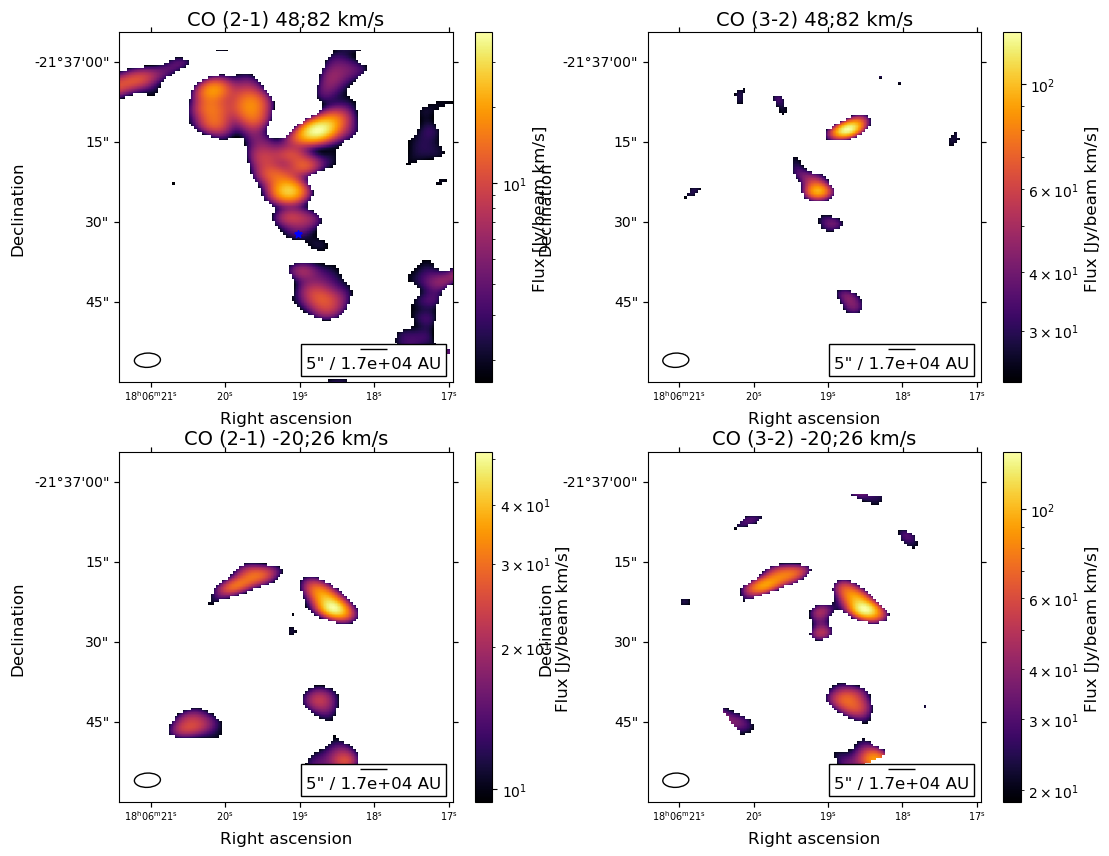

In [143]:
#here the maps are plotted
#Did B7 for wcs because it is the one that is not regridded
fig, ax = plt.subplots(2, 2, figsize=(12.5,10), subplot_kw={'projection': wcs_B7_red}) #horizontal size: 25,9.5

#CO21 redshifted
ax[0,0].imshow(B6_red_clip.value, origin='lower', cmap='inferno', norm=norm_6_red)
ax[0,0].set_title('CO (2-1) ' + red_velrange_text + ' km/s')
ax[0,0].set_xlabel('Right ascension')
ax[0,0].set_ylabel('Declination')
v.add_beam(ax=ax[0,0],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[0,0].set_xlim(0, 120)
ax[0,0].set_ylim(0, 126)
ax[0,0].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[0,0], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_6_red, ax=ax[0,0], label='Flux [Jy/beam km/s]')

#CO32 redshifted
ax[0,1].imshow(B7_red_clip.value, origin='lower', cmap='inferno', norm=norm_7_red)
ax[0,1].set_title('CO (3-2) ' + red_velrange_text + ' km/s')
ax[0,1].set_xlabel('Right ascension')
ax[0,1].set_ylabel('Declination')
v.add_beam(ax=ax[0,1],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[0,1].set_xlim(0, 120)
ax[0,1].set_ylim(0, 126)
ax[0,1].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[0,1], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_7_red, ax=ax[0,1], label='Flux [Jy/beam km/s]')

#CO21 blueshifted
ax[1,0].imshow(B6_blue_clip.value, origin='lower', cmap='inferno', norm=norm_6_blue)
ax[1,0].set_title('CO (2-1) ' + blue_velrange_text + ' km/s')
ax[1,0].set_xlabel('Right ascension')
ax[1,0].set_ylabel('Declination')
v.add_beam(ax=ax[1,0],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[1,0].set_xlim(0, 120)
ax[1,0].set_ylim(0, 126)
ax[1,0].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[1,0], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_6_blue, ax=ax[1,0], label='Flux [Jy/beam km/s]')

#CO32 blueshifted
ax[1,1].imshow(B7_blue_clip.value, origin='lower', cmap='inferno', norm=norm_7_blue)
ax[1,1].set_title('CO (3-2) ' + blue_velrange_text + ' km/s')
ax[1,1].set_xlabel('Right ascension')
ax[1,1].set_ylabel('Declination')
v.add_beam(ax=ax[1,1],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[1,1].set_xlim(0, 120)
ax[1,1].set_ylim(0, 126)
ax[1,1].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[1,1], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_7_blue, ax=ax[1,1], label='Flux [Jy/beam km/s]')

ax[0,0].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[0,0].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores', zorder=10)
ax[0,1].scatter(hot_cores_RB, hot_cores_DEC, transform=ax[0,1].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores', zorder=10)
ax[1,0].scatter(hot_cores_RB, hot_cores_DEC, transform=ax[1,0].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores', zorder=10)
ax[1,1].scatter(hot_cores_RB, hot_cores_DEC, transform=ax[1,1].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores', zorder=10)

ax[0,0].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[0,0].get_transform('fk5'), s=30, 
              color='red', marker='*', label='Bll cores')
ax[0,1].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[0,1].get_transform('fk5'), s=30,
                color='red', marker='*', label='Bll cores')
ax[1,0].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[1,0].get_transform('fk5'), s=30,
                color='red', marker='*', label='Bll cores')
ax[1,1].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[1,1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')

regions = Regions.read('/net/vdesk/data2/bach1/ballieux/master_project_2/data/high_mass_data/apertures_paths_pvdiagrams/G008.67_all', format='crtf')
for region in regions:
    pixel_region = region.to_pixel(wcs_B7_red)
    pixel_region.plot(ax=ax[0,0], linewidth=1)
    pixel_region.plot(ax=ax[0,1], linewidth=1)
    pixel_region.plot(ax=ax[1,0], linewidth=1)
    pixel_region.plot(ax=ax[1,1], linewidth=1)

plt.subplots_adjust(wspace=0.5)
plt.savefig(path+'plots/maps_'+source_name+'.png', bbox_inches='tight', dpi=500)

# LTE Radiative Transfer Magic:

In [34]:
"""
here we do the rotation diagram magic
"""
#beamsize, defined above in arcseconds:
cb_omega = np.pi*((beam_major).to(u.rad).value)*((beam_minor).to(u.rad).value)

#Einstein A coefficients from cmds
A_B6_CO = 10**(-6.1605) /u.s 
A_B7_CO = 10**(-5.6026) /u.s 


In [35]:
#Assuming optically thin:
def column_dens_thin(mom0, A, omega):
    """
    Determine the column density of a molecule in the optically thin limit. since it gives an overflow error, and 
    returns only infinite sometimes, we first multiply the denomenator with 1e38 and later multiply the whole again by 1e38 to get the correct units.
    """
    numerator = 4 * np.pi * mom0 
    denomenator = A * omega * c.h * c.c *1e38
    coldens = numerator / denomenator  
    return coldens.to(u.cm**(-2)) *1e38

In [36]:
#Determine the column densities in the 2 bands for the red and blueshifted lines
coldens_B6_CO_red = column_dens_thin(B6_red_clip, A_B6_CO, cb_omega)
coldens_B7_CO_red = column_dens_thin(B7_red_clip, A_B7_CO, cb_omega)
coldens_B6_CO_blue = column_dens_thin(B6_blue_clip, A_B6_CO, cb_omega)
coldens_B7_CO_blue = column_dens_thin(B7_blue_clip, A_B7_CO, cb_omega)


In [37]:
# coldens_red_mask_behaved = (coldens_B6_CO_red.value<7.91e15) & (coldens_B7_CO_red.value<5.54e15)
# coldens_blue_mask_behaved = (coldens_B6_CO_blue.value<7.91e15) & (coldens_B7_CO_blue.value<5.54e15)

#from cdms, the degeneracies of the CO molecule
g_B6 = 5
g_B7 = 7

#Rest frequencies
freq_B6_CO = 230538.0000 *u.Hz
freq_B7_CO = 345795.9899 *u.Hz

#Lower energies
El_B6_CO = 3.8450 *1.438 * u.K #*u.cm**(-1)*c.h*c.c
El_B7_CO = 11.5350*1.438 * u.K#*u.cm**(-1)*c.h*c.c

Eu_B6_CO = 11.5350 * 1.438 * u.K
Eu_B7_CO = 23.0695 * 1.438 * u.K

In [38]:
#here we calculate the rotational temperatures, unmasked
rot_ratio_CO_red = (np.log(coldens_B6_CO_red.value/g_B6)-np.log(coldens_B7_CO_red.value/g_B7))/(Eu_B6_CO-Eu_B7_CO)
rot_ratio_CO_blue = (np.log(coldens_B6_CO_blue.value/g_B6)-np.log(coldens_B7_CO_blue.value/g_B7))/(Eu_B6_CO-Eu_B7_CO)

Tk_CO_red = -1/rot_ratio_CO_red
Tk_CO_blue = -1/rot_ratio_CO_blue


"""   
The propagation of errors is done in the following way:
find uncertainty in the line column densities which is linearly dependent on the error in the moment 0 map, 
so just enter into the equation. Then we have a formula for the slope, so standard prop of errors
gives us the uncertainty in the slope. The rotational temperature is then calculated from the slope, so we can
do more standard propagation of errors to find the uncertainty in the rotational temperature.

"""
sigma_coldens_B6_red = column_dens_thin(B6_red_err, A_B6_CO, cb_omega) 
sigma_coldens_B6_blue = column_dens_thin(B6_blue_err, A_B6_CO, cb_omega)
sigma_coldens_B7_red = column_dens_thin(B7_red_err, A_B7_CO, cb_omega)
sigma_coldens_B7_blue = column_dens_thin(B7_blue_err, A_B7_CO, cb_omega)

#from prop of errors
sigma_slope_red = np.sqrt(((sigma_coldens_B6_red/coldens_B6_CO_red)/(Eu_B6_CO-Eu_B7_CO))**2 + ((sigma_coldens_B7_red/coldens_B7_CO_red)/(Eu_B6_CO-Eu_B7_CO))**2)
sigma_slope_blue = np.sqrt(((sigma_coldens_B6_blue/coldens_B6_CO_blue)/(Eu_B6_CO-Eu_B7_CO))**2 + ((sigma_coldens_B7_blue/coldens_B7_CO_blue)/(Eu_B6_CO-Eu_B7_CO))**2)

#The errors on the rotational temperatures
sigma_Tk_red = sigma_slope_red/(rot_ratio_CO_red**2)
sigma_Tk_blue = sigma_slope_blue/(rot_ratio_CO_blue**2)

#For visualisation later, the min, max or mean is not representative
print('Tk red:', np.mean(Tk_CO_red[~np.isnan(Tk_CO_red)]), 'Tk blue:', np.mean(Tk_CO_blue[~np.isnan(Tk_CO_blue)]))
print('Tk red max:', np.max(Tk_CO_red[~np.isnan(Tk_CO_red)]), 'Tk blue max:', np.max(Tk_CO_blue[~np.isnan(Tk_CO_blue)])) #This probably includes off pixels
print('Tk red min:', np.min(Tk_CO_red[~np.isnan(Tk_CO_red)]), 'Tk blue min:', np.min(Tk_CO_blue[~np.isnan(Tk_CO_blue)])) #This includes negative pixels
print('sigma_Tk red:', np.mean(sigma_Tk_red[~np.isnan(sigma_Tk_red)]), 'sigma_Tk blue:', np.mean(sigma_Tk_blue[~np.isnan(sigma_Tk_blue)]))

Tk red: 20.036567976610975 K Tk blue: 27.170475556856065 K
Tk red max: 719.1153795963626 K Tk blue max: 214.08120912287583 K
Tk red min: -1599.398884157005 K Tk blue min: 11.985318706295573 K
sigma_Tk red: 242.4122356261462 K sigma_Tk blue: 19.131227322516406 K


In [39]:
#required to plot the colorbars
norm_T = mpl.colors.LogNorm(vmin=1e1, vmax=1e2)
norm_d = mpl.colors.LogNorm(vmin=3e15, vmax=2e16)
sm_T = cm.ScalarMappable(norm=norm_T, cmap=cmap)
sm_d = cm.ScalarMappable(norm=norm_d, cmap=cmap)

In [40]:
#interpolate to find the partition function for each pixel
Z_CO = np.array([1.4053, 2.1824, 3.7435, 7.1223, 13.8965, 27.4545, 54.5814, 81.7184, 108.8651, 181.3025, 362.6910, 726.7430])
T = np.array([2.725, 5.000, 9.375, 18.75, 37.5, 75, 150, 225, 300, 500, 1000, 2000])*u.K

#Everything that behaves as expected in terms of temperature
temp_behaved_mask_CO_red = (Tk_CO_red<200*u.K) & (Tk_CO_red>1*u.K)
temp_behaved_mask_CO_blue = (Tk_CO_blue<200*u.K) & (Tk_CO_blue>1*u.K)

#this is the temperatures where column density behaves
Tk_CO_red_behaved = np.copy(Tk_CO_red)
Tk_CO_red_behaved[np.logical_not(temp_behaved_mask_CO_red)] = np.nan
Tk_CO_blue_behaved = np.copy(Tk_CO_blue)
Tk_CO_blue_behaved[np.logical_not(temp_behaved_mask_CO_blue)] = np.nan

sigma_Tk_red_behaved = np.copy(sigma_Tk_red)
sigma_Tk_red_behaved[np.logical_not(temp_behaved_mask_CO_red)] = np.nan
sigma_Tk_blue_behaved = np.copy(sigma_Tk_blue)
sigma_Tk_blue_behaved[np.logical_not(temp_behaved_mask_CO_blue)] = np.nan

Z_interp_CO = interp.interp1d(T, Z_CO, kind='linear', fill_value='extrapolate')

Z_CO_red = Z_interp_CO(Tk_CO_red)
Z_CO_blue = Z_interp_CO(Tk_CO_blue)



In [41]:
def N_tot(N_u, g_u, Z, E_u, Tk):

    """
    Determine the total column density of a molecule in the optically thin limit.
    """
    return N_u*Z*np.exp(E_u/Tk)/g_u

#determine the total column densities, even for the ones that are optically thick to see how it behaves
N_B6_CO_red = N_tot(coldens_B6_CO_red, g_B6, Z_CO_red, Eu_B6_CO, Tk_CO_red)
N_B6_CO_blue = N_tot(coldens_B6_CO_blue, g_B6, Z_CO_blue, Eu_B6_CO, Tk_CO_blue)

N_B6_CO_red_behaved = np.copy(N_B6_CO_red)
N_B6_CO_red_behaved[np.logical_not(temp_behaved_mask_CO_red)] = np.nan
N_B6_CO_blue_behaved = np.copy(N_B6_CO_blue)
N_B6_CO_blue_behaved[np.logical_not(temp_behaved_mask_CO_blue)] = np.nan

print('N red:', np.mean(N_B6_CO_red_behaved[~np.isnan(N_B6_CO_red_behaved)]), 'N blue:', np.mean(N_B6_CO_blue_behaved[~np.isnan(N_B6_CO_blue_behaved)]))


N red: 6324123897294189.0 1 / cm2 N blue: 6924307851880950.0 1 / cm2


In [42]:
"""  
Uncertainty in coldens
We do propagation of errors on the formula for Ntot. 3 parameters that are uncertain: N_u, Tk en Z. 
Ignore uncertainty on Z, do standard prop of errors on N_u and Tk.
"""

sigma_Ntot_B6_red = np.sqrt((N_tot(sigma_coldens_B6_red, g_B6, Z_CO_red, Eu_B6_CO, Tk_CO_red))**2 + (N_B6_CO_red*Eu_B6_CO*sigma_Tk_red/(g_B6*Tk_CO_red**2))**2)
sigma_Ntot_B6_blue = np.sqrt((N_tot(sigma_coldens_B6_blue, g_B6, Z_CO_blue, Eu_B6_CO, Tk_CO_blue))**2 + (N_B6_CO_blue*Eu_B6_CO*sigma_Tk_blue/(g_B6*Tk_CO_blue**2))**2)

sigma_Ntot_B6_red_behaved = np.copy(sigma_Ntot_B6_red)
sigma_Ntot_B6_red_behaved[np.logical_not(temp_behaved_mask_CO_red)] = np.nan
sigma_Ntot_B6_blue_behaved = np.copy(sigma_Ntot_B6_blue)
sigma_Ntot_B6_blue_behaved[np.logical_not(temp_behaved_mask_CO_blue)] = np.nan

print('sigma N red:', np.mean(sigma_Ntot_B6_red_behaved[~np.isnan(sigma_Ntot_B6_red_behaved)]), 'sigma N blue:', np.mean(sigma_Ntot_B6_blue_behaved[~np.isnan(sigma_Ntot_B6_blue_behaved)]))


sigma N red: 737411875829804.5 1 / cm2 sigma N blue: 1360250119786371.0 1 / cm2


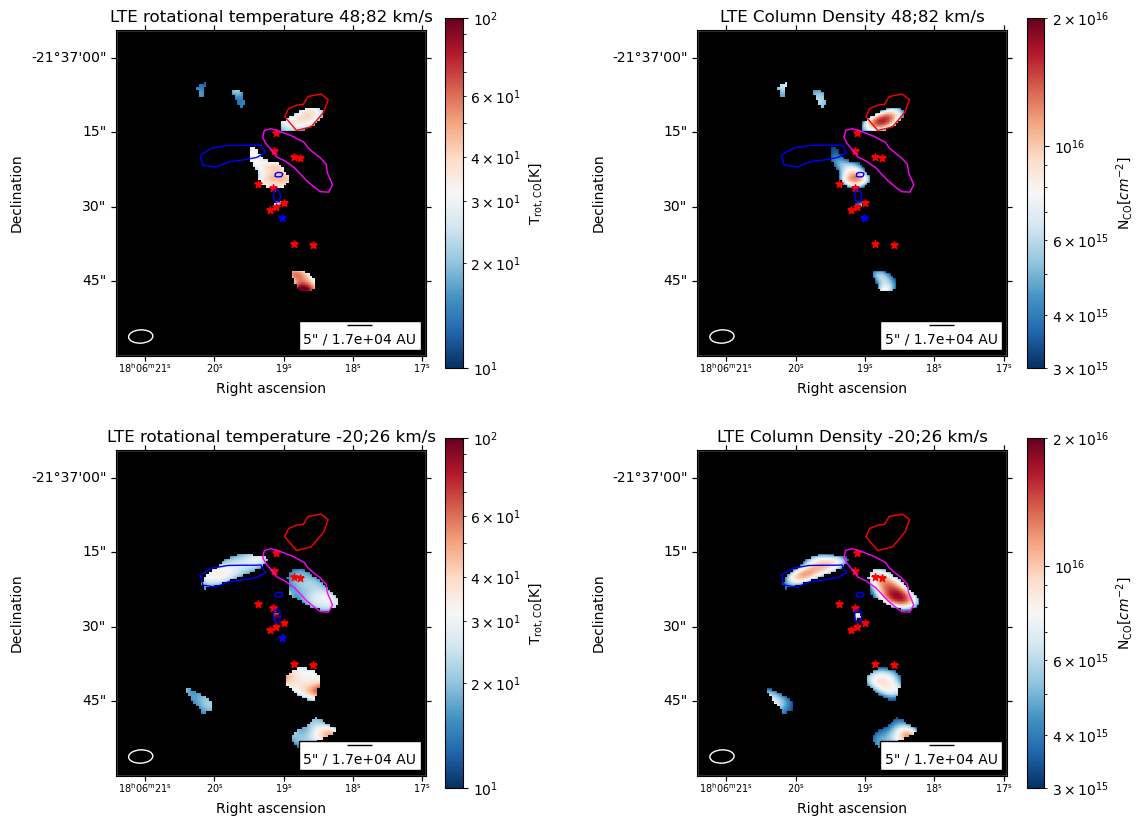

In [43]:
#Do the plottomg pf rotational temperature and total column density
fig, ax = plt.subplots(2,2, figsize=(12.5,10), subplot_kw={'projection': wcs_B7_red}) #size horizontal: 20,9.5

#temp red
ax[0,0].imshow(Tk_CO_red_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_T)
ax[0,0].set_facecolor('black')
ax[0,0].set_title('LTE rotational temperature '+red_velrange_text+' km/s')
ax[0,0].set_xlabel('Right ascension')
ax[0,0].set_ylabel('Declination')
v.add_beam(ax=ax[0,0],major=beam_major, minor=beam_minor, angle=beam_pa, color='black', edgecolor='white')
ax[0,0].set_xlim(0,120)
ax[0,0].set_ylim(0,126)
ax[0,0].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[0,0], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_T, ax=ax[0,0], label=r'T$_{\mathrm{rot,CO}}$[K]')

#temp blue
ax[1,0].imshow(Tk_CO_blue_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_T)
ax[1,0].set_facecolor('black')
ax[1,0].set_title('LTE rotational temperature '+blue_velrange_text+' km/s')
ax[1,0].set_xlabel('Right ascension')
ax[1,0].set_ylabel('Declination')
ax[1,0].set_xlim(0, 120)
ax[1,0].set_ylim(0, 126)
v.add_beam(ax=ax[1,0],major=beam_major, minor=beam_minor, angle=beam_pa, color='black', edgecolor='white')
ax[1,0].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[1,0], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_T, ax=ax[1,0], label=r'T$_{\mathrm{rot,CO}}$[K]')

#coldens red
ax[0,1].imshow(N_B6_CO_red_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_d)
ax[0,1].set_facecolor('black')
ax[0,1].set_title('LTE Column Density '+red_velrange_text+' km/s')
ax[0,1].set_xlabel('Right ascension')
ax[0,1].set_ylabel('Declination')
ax[0,1].set_xlim(0,120)
ax[0,1].set_ylim(0,126)
v.add_beam(ax=ax[0,1],major=beam_major, minor=beam_minor, angle=beam_pa, color='black', edgecolor='white')
ax[0,1].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[0,1], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_d, ax=ax[0,1], label=r'N$_{\mathrm{CO}}[cm^{-2}]$')

#coldens blue
ax[1,1].imshow(N_B6_CO_blue_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_d)
ax[1,1].set_facecolor('black')
ax[1,1].set_title('LTE Column Density '+blue_velrange_text+' km/s')
ax[1,1].set_xlabel('Right ascension')
ax[1,1].set_ylabel('Declination')
ax[1,1].set_xlim(0, 120)
ax[1,1].set_ylim(0, 126)
v.add_beam(ax=ax[1,1],major=beam_major, minor=beam_minor, angle=beam_pa, color='black', edgecolor='white')
ax[1,1].tick_params(axis='x', labelsize=7)
v.add_scalebar(ax[1,1], length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU", frame=True, pad=0.3)
fig.colorbar(mappable=sm_d, ax=ax[1,1], label=r'N$_{\mathrm{CO}}[cm^{-2}]$')

ax[0,0].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[0,0].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores', zorder=10)
ax[0,1].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[0,1].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores', zorder=10)
ax[1,0].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[1,0].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores', zorder=10)
ax[1,1].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[1,1].get_transform('fk5'), s=30,
           color='black', marker='*', label='Hot cores', zorder=10)

ax[0,0].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[0,0].get_transform('fk5'), s=30, 
              color='red', marker='*', label='All cores')
ax[0,1].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[0,1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
ax[1,0].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[1,0].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
ax[1,1].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[1,1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')

for region in regions:
    pixel_region = region.to_pixel(wcs_B7_red)
    pixel_region.plot(ax=ax[0,0], linewidth=1)
    pixel_region.plot(ax=ax[0,1], linewidth=1)
    pixel_region.plot(ax=ax[1,0], linewidth=1)
    pixel_region.plot(ax=ax[1,1], linewidth=1)

plt.subplots_adjust(wspace=0.5)
plt.savefig(path+'plots/LTE_tempmaps_'+source_name+'.png', dpi=500, bbox_inches='tight')

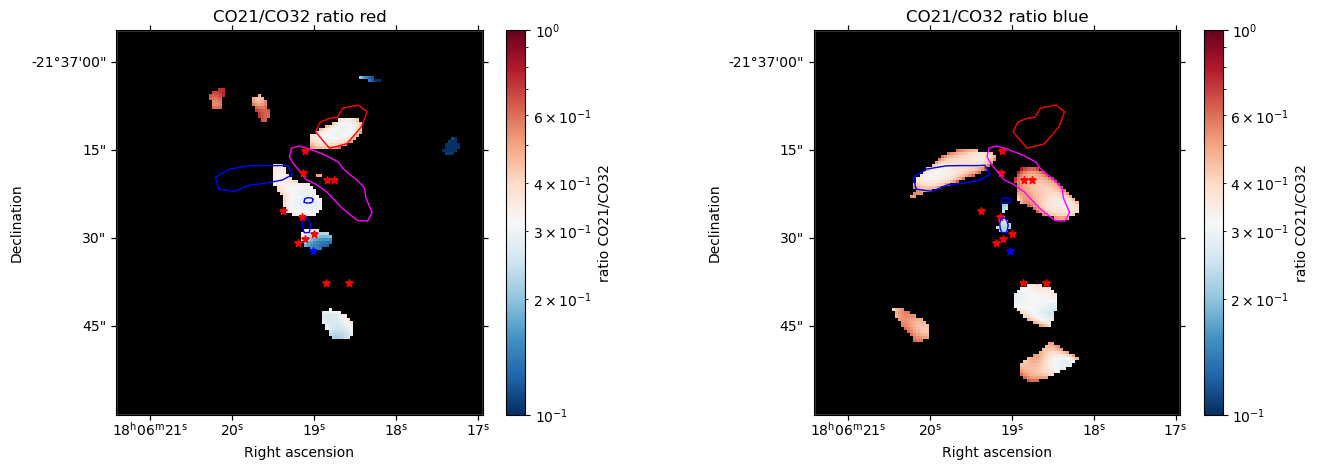

In [44]:
#required to plot the colorbars
norm_ratio = mpl.colors.LogNorm(vmin=1e-1, vmax=1e0)
sm_ratio = cm.ScalarMappable(norm=norm_ratio, cmap=cmap)

#trying to figure out why some spots disappear/are very high
fig, ax = plt.subplots(1,2, figsize=(15,5), subplot_kw={'projection': wcs_B7_red}) #size horizontal: 20,9.5

#ratio red
ax[0].imshow(B6_red_clip/B7_red_clip, origin='lower', cmap='RdBu_r', norm=norm_ratio)
ax[0].set_facecolor('black')
ax[0].set_title('CO21/CO32 ratio red')
ax[0].set_xlabel('Right ascension')
ax[0].set_ylabel('Declination')
v.add_beam(ax=ax[0],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[0].set_xlim(0, 120)
ax[0].set_ylim(0, 126)
v.add_scalebar(ax[0], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
fig.colorbar(mappable=sm_ratio, ax=ax[0], label='ratio CO21/CO32')

#ratio blue
ax[1].imshow(B6_blue_clip/B7_blue_clip, origin='lower', cmap='RdBu_r', norm=norm_ratio)
ax[1].set_facecolor('black')
ax[1].set_title('CO21/CO32 ratio blue')
ax[1].set_xlabel('Right ascension')
ax[1].set_ylabel('Declination')
v.add_beam(ax=ax[1],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[1].set_xlim(0, 120)
ax[1].set_ylim(0, 126)
v.add_scalebar(ax[1], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
fig.colorbar(mappable=sm_ratio, ax=ax[1], label='ratio CO21/CO32')


ax[0].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[0].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores')
ax[1].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[1].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores')

ax[0].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[0].get_transform('fk5'), s=30, 
              color='red', marker='*', label='All cores', zorder=100)
ax[1].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
for region in regions:
    pixel_region = region.to_pixel(wcs_B7_red)
    pixel_region.plot(ax=ax[0], linewidth=1)
    pixel_region.plot(ax=ax[1], linewidth=1)

plt.subplots_adjust(wspace=0.5)
plt.savefig(path+'plots/ratio_flux.png', bbox_inches='tight')

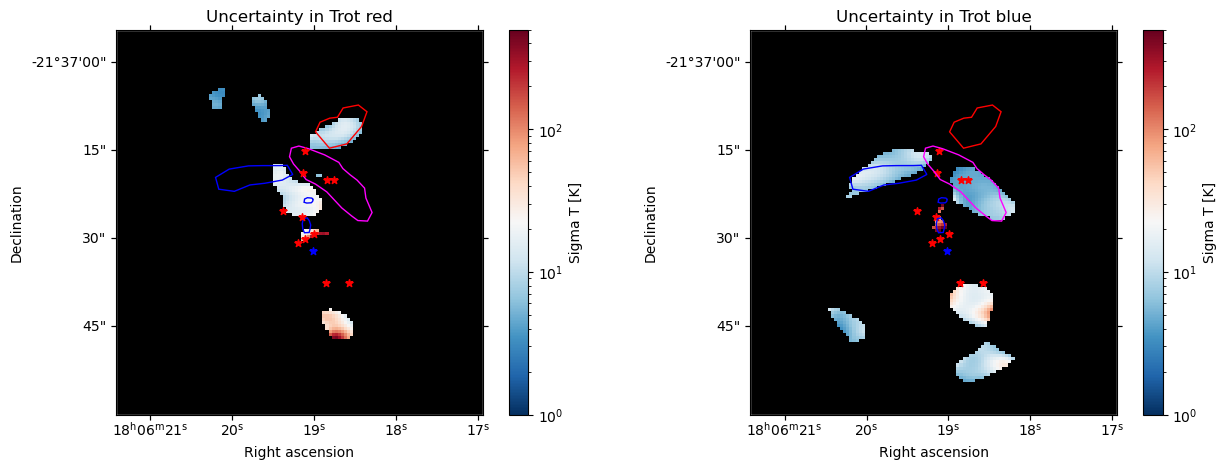

In [45]:
"""   
Plot the sigma on temperature
"""

#required to plot the colorbars
norm_ratio_sigma_T = mpl.colors.LogNorm(vmin=1, vmax=5e2)
sm_ratio_sigma_T = cm.ScalarMappable(norm=norm_ratio_sigma_T, cmap=cmap)

#trying to figure out why some spots disappear/are very high
fig, ax = plt.subplots(1,2, figsize=(15,5), subplot_kw={'projection': wcs_B7_red}) #size horizontal: 20,9.5

#ratio red
ax[0].imshow(sigma_Tk_red_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_ratio_sigma_T)
ax[0].set_facecolor('black')
ax[0].set_title('Uncertainty in Trot red')
ax[0].set_xlabel('Right ascension')
ax[0].set_ylabel('Declination')
v.add_beam(ax=ax[0],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[0].set_xlim(0, 120)
ax[0].set_ylim(0, 126)
v.add_scalebar(ax[0], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
fig.colorbar(mappable=sm_ratio_sigma_T, ax=ax[0], label='Sigma T [K]')

#ratio blue
ax[1].imshow(sigma_Tk_blue_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_ratio_sigma_T)
ax[1].set_facecolor('black')
ax[1].set_title('Uncertainty in Trot blue')
ax[1].set_xlabel('Right ascension')
ax[1].set_ylabel('Declination')
v.add_beam(ax=ax[1],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[1].set_xlim(0, 120)
ax[1].set_ylim(0, 126)
v.add_scalebar(ax[1], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
fig.colorbar(mappable=sm_ratio_sigma_T, ax=ax[1], label='Sigma T [K]')


ax[0].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[0].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores')
ax[1].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[1].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores')

ax[0].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[0].get_transform('fk5'), s=30, 
              color='red', marker='*', label='All cores', zorder=100)
ax[1].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
for region in regions:
    pixel_region = region.to_pixel(wcs_B7_red)
    pixel_region.plot(ax=ax[0], linewidth=1)
    pixel_region.plot(ax=ax[1], linewidth=1)

# plt.subplots_adjust(wspace=0.5)
# plt.savefig(path+'plots/ratio_flux.png', bbox_inches='tight')

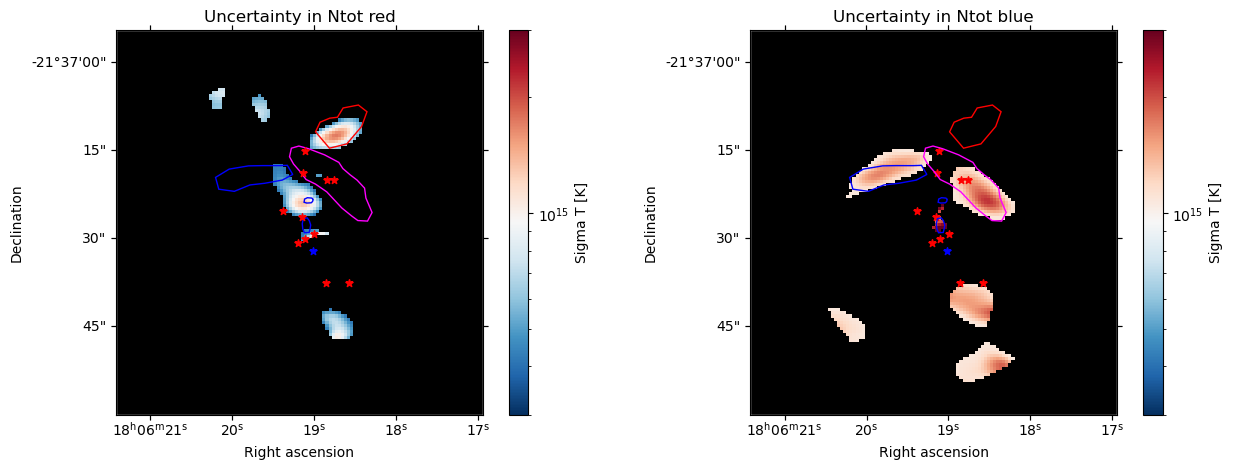

In [46]:
"""   
Plot the sigma on uncertainty

"""

#required to plot the colorbars
norm_ratio_sigma_N = mpl.colors.LogNorm(vmin=3e14, vmax=3e15)
sm_ratio_sigma_N = cm.ScalarMappable(norm=norm_ratio_sigma_N, cmap=cmap)

#trying to figure out why some spots disappear/are very high
fig, ax = plt.subplots(1,2, figsize=(15,5), subplot_kw={'projection': wcs_B7_red}) #size horizontal: 20,9.5

#ratio red
ax[0].imshow(sigma_Ntot_B6_red_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_ratio_sigma_N)
ax[0].set_facecolor('black')
ax[0].set_title('Uncertainty in Ntot red')
ax[0].set_xlabel('Right ascension')
ax[0].set_ylabel('Declination')
v.add_beam(ax=ax[0],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[0].set_xlim(0, 120)
ax[0].set_ylim(0, 126)
v.add_scalebar(ax[0], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
fig.colorbar(mappable=sm_ratio_sigma_N, ax=ax[0], label='Sigma T [K]')

#ratio blue
ax[1].imshow(sigma_Ntot_B6_blue_behaved.value, origin='lower', cmap='RdBu_r', norm=norm_ratio_sigma_N)
ax[1].set_facecolor('black')
ax[1].set_title('Uncertainty in Ntot blue')
ax[1].set_xlabel('Right ascension')
ax[1].set_ylabel('Declination')
v.add_beam(ax=ax[1],major=beam_major, minor=beam_minor, angle=beam_pa, color='none', edgecolor='black')
ax[1].set_xlim(0, 120)
ax[1].set_ylim(0, 126)
v.add_scalebar(ax[1], length=1*u.arcsec, label=f"1\" / {((1*u.arcsec).to(u.rad)*d.to(u.pc)).value:.2} pc")
fig.colorbar(mappable=sm_ratio_sigma_N, ax=ax[1], label='Sigma T [K]')


ax[0].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[0].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores')
ax[1].scatter(hot_cores_RA, hot_cores_DEC, transform=ax[1].get_transform('fk5'), s=30,
           color='blue', marker='*', label='Hot cores')

ax[0].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[0].get_transform('fk5'), s=30, 
              color='red', marker='*', label='All cores', zorder=100)
ax[1].scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax[1].get_transform('fk5'), s=30,
                color='red', marker='*', label='All cores')
for region in regions:
    pixel_region = region.to_pixel(wcs_B7_red)
    pixel_region.plot(ax=ax[0], linewidth=1)
    pixel_region.plot(ax=ax[1], linewidth=1)

# plt.subplots_adjust(wspace=0.5)
# plt.savefig(path+'plots/ratio_flux.png', bbox_inches='tight')

36.34652276144767 K 26.729409411339958 K
26.87617915931287 K 16.840027411354058 K
6.324e+15 1 / cm2, 6.924e+15 1 / cm2
7.374e+14 1 / cm2, 1.36e+15 1 / cm2


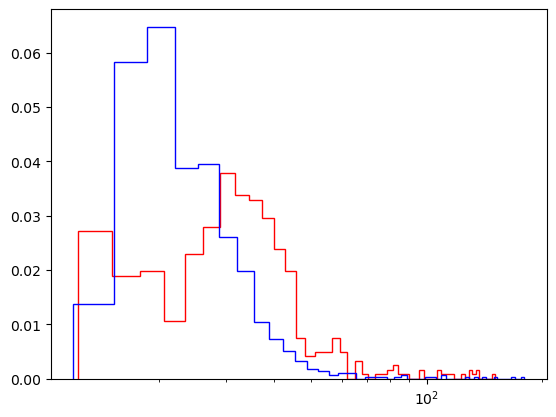

In [47]:
"""  
I want to determine the mean temp, in the red and blue map. Do not seperate the different outflows. Only include the pixels that do belong to outflows though,
so not the noise on edges of the fields. But that is not a problem here I guess
"""
plt.hist(Tk_CO_red_behaved[~np.isnan(Tk_CO_red_behaved)].value, bins=50, histtype='step', color='red', label='red', density=True)
plt.hist(Tk_CO_blue_behaved[~np.isnan(Tk_CO_blue_behaved)].value, bins=50, histtype='step', color='blue', label='blue', density=True)
plt.semilogx()

print(np.mean(Tk_CO_red_behaved[~np.isnan(Tk_CO_red_behaved)]), np.mean(Tk_CO_blue_behaved[~np.isnan(Tk_CO_blue_behaved)]))
print(np.mean(sigma_Tk_red_behaved[~np.isnan(sigma_Tk_red_behaved)]), np.mean(sigma_Tk_blue_behaved[~np.isnan(sigma_Tk_blue_behaved)]))
# print(np.std(Tk_CO_red_behaved[~np.isnan(Tk_CO_red_behaved)]), np.std(Tk_CO_blue_behaved[~np.isnan(Tk_CO_blue_behaved)]))
print(f'{np.mean(N_B6_CO_red_behaved[~np.isnan(N_B6_CO_red_behaved)]):.4}, {np.mean(N_B6_CO_blue_behaved[~np.isnan(N_B6_CO_blue_behaved)]):.4}')
print(f'{np.mean(sigma_Ntot_B6_red_behaved[~np.isnan(sigma_Ntot_B6_red_behaved)]):.4}, {np.mean(sigma_Ntot_B6_blue_behaved[~np.isnan(sigma_Ntot_B6_blue_behaved)]):.4}')

In [48]:
"""
here, make contour maps for unsmoothed CO21

"""

B6_red_name_unsmoothed = 'region_selection/CO21_M0_48_82_unsmoothed.fits'    #M0 map of the CO 2-1 line, band 6, redshifted, unsmoothed
B6_blue_name_unsmoothed = 'region_selection/CO21_M0_-20_26_unsmoothed.fits'    #M0 map of the CO 2-1 line, band 6, blueshifted, unsmoothed

#Open the fits files
hdu_B6_red_unsmoothed = fits.open(path+B6_red_name_unsmoothed)
hdu_B6_blue_unsmoothed = fits.open(path+B6_blue_name_unsmoothed)

# Always manually check the beam is exactly the same for both maps, and check unit of major axis
beam_major_unsmoothed = hdu_B6_red_unsmoothed[0].header['BMAJ']*3600 *u.arcsec # Beam major axis size in arcseconds
beam_minor_unsmoothed = hdu_B6_red_unsmoothed[0].header['BMIN']*3600 *u.arcsec # Beam minor axis size in arcseconds
beam_pa_unsmoothed = hdu_B6_red_unsmoothed[0].header['BPA']*u.deg  # Beam position angle in degrees

pixel_size_unsmoothed = 0.11 * u.arcsec


#The WCS object is used to convert between pixel and world coordinates
wcs_B6_red_unsmoothed = WCS(hdu_B6_red_unsmoothed[0].header)
wcs_B6_blue_unsmoothed = WCS(hdu_B6_blue_unsmoothed[0].header)

#One of the images needs to be regridded, this can be done because both are well sampled
#This is the one where CO32 has a worse resolution than CO21
B6_red_unsmoothed = hdu_B6_red_unsmoothed[0].data *u.Jy*u.km/u.s
B6_blue_unsmoothed = hdu_B6_blue_unsmoothed[0].data *u.Jy*u.km/u.s


#RMS calculation
B6_red_rms_name_unsmoothed = 'region_selection/CO21_M0_'+ red_velrange+ '_unsmoothed_rms.fits'    #empty region of M0 map of the CO 2-1 line, band 6, shape does not matter
B6_blue_rms_name_unsmoothed = 'region_selection/CO21_M0_'+ blue_velrange+ '_unsmoothed_rms.fits'    #empty region of M0 map of the CO 2-1 line, band 6, shape does not matter


#This is now just an empty region of the map to get rms level. Later convolve with 10%
hdu_B6_red_err_unsmoothed = fits.open(path+B6_red_rms_name_unsmoothed)
hdu_B6_blue_err_unsmoothed = fits.open(path+B6_blue_rms_name_unsmoothed)


#Here we take the not-nan values to calculate the rms. The other images do still contain nan values
B6_red_rms_unsmoothed = np.sqrt(np.mean(np.square(hdu_B6_red_err_unsmoothed[0].data[hdu_B6_red_err_unsmoothed[0].data >0]) ))*u.Jy*u.km/u.s
B6_blue_rms_unsmoothed = np.sqrt(np.mean(np.square(hdu_B6_blue_err_unsmoothed[0].data[hdu_B6_blue_err_unsmoothed[0].data >0]) ))*u.Jy*u.km/u.s
print(B6_red_rms_unsmoothed, B6_blue_rms_unsmoothed)
#Also convolution with 10% systematic error

systematic_error = 0.1 # 10% systematic error
B6_red_err_unsmoothed = np.sqrt(np.square(B6_red_rms_unsmoothed) + np.square(systematic_error* B6_red_unsmoothed))
B6_blue_err_unsmoothed = np.sqrt(np.square(B6_blue_rms_unsmoothed) + np.square(systematic_error* B6_blue_unsmoothed))

hdu_B6_red_unsmoothed.close()
hdu_B6_red_err_unsmoothed.close()
hdu_B6_blue_unsmoothed.close()
hdu_B6_blue_err_unsmoothed.close()

0.07092488557100296 Jy km / s 0.14482590556144714 Jy km / s


In [49]:

#Determine the SNR
SNR_B6_red_unsmoothed = B6_red_unsmoothed/B6_red_err_unsmoothed
SNR_B6_blue_unsmoothed = B6_blue_unsmoothed/B6_blue_err_unsmoothed

clip = 3

B6_red_clip_unsmoothed = np.copy(B6_red_unsmoothed)
B6_blue_clip_unsmoothed = np.copy(B6_blue_unsmoothed)

B6_red_clip_unsmoothed[SNR_B6_red_unsmoothed<clip] = np.nan
B6_blue_clip_unsmoothed[SNR_B6_blue_unsmoothed<clip] = np.nan

B6_red_clip_unsmoothed[B6_red_clip_unsmoothed==0] = np.nan
B6_blue_clip_unsmoothed[B6_blue_clip_unsmoothed==0] = np.nan

Length of the line blue lobe A: 5.181e+04 pm 5.911e+03 AU
Length of the line red lobe A: 3.864e+04 pm 4.799e+03 AU
Length of the line blue lobe B: 5.181e+04 pm 5.911e+03 AU
Length of the line red lobe B: 2.035e+04 pm 4.799e+03 AU

Delta V blue A 64.0 km / s pm 6.4 km / s
Delta V red A 38.9 km / s pm 3.89 km / s
Delta V blue B 53.8 km / s pm 5.38 km / s
Delta V red B 36.4 km / s pm 3.64 km / s

The blue A dynamic time is 3.838e+03 pm 582.2 years
The red A dynamic time is 4.709e+03 pm 750.8 years
The blue B dynamic time is 3.013e+03 pm 494.4 years
The red B dynamic time is 2.65e+03 pm 527.1 years


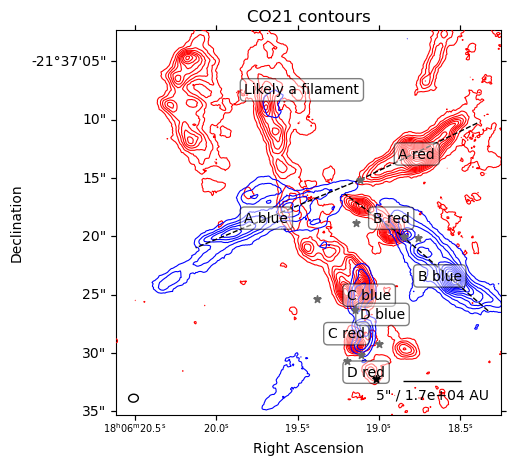

In [50]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': wcs_B6_red_unsmoothed}) #size horizontal: 20,9.5
plt.title('CO21 contours')

# Plot the contours of B6_red_clip. since it is already clipped at 3 sigma, no need to do it again. This goed allright, it does not need to be 3sigma for b6 _and_ b7.
contourlevels_red=np.array([3,8,13,18,23,28,33,38,43,48,53,58,63,68,73,78])*B6_red_rms_unsmoothed
ax.contour(B6_red_unsmoothed.value, levels=contourlevels_red, colors='red', linewidths=0.8)

# Plot the contours of B6_blue_clip
contourlevels_blue=np.array([3,8,13,18,23,28,33,38,43,48,53,58,63,68,73,78])*B6_blue_rms_unsmoothed
ax.contour(B6_blue_unsmoothed.value, levels=contourlevels_blue, colors='blue', linewidths=0.8)

# Set the aspect ratio to be equal
ax.set_aspect('equal')


# Set the limits for zooming
ax.set_xlim(700,1000)
ax.set_ylim(350,650)

# Add labels
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

plt.text(800,600, 'Likely a filament', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=0.5))

plt.text(800,500, 'A blue', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=0.5))
plt.text(920,550, 'A red', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=0.5))
plt.text(935,455, 'B blue', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=0.5))
plt.text(900,500, 'B red', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=0.5))
plt.text(880,440, 'C blue', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=0.5))
plt.text(865,410, 'C red', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=0.5))
plt.text(890,425, 'D blue', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=0.5))
plt.text(880,380, 'D red', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=0.5))

v.add_beam(ax=ax,major=beam_major_unsmoothed, minor=beam_minor_unsmoothed, angle=beam_pa_unsmoothed, color='none', edgecolor='black')
ax.tick_params(axis='x', labelsize=7)
v.add_scalebar(ax, length=5*u.arcsec, label=f"5\" / {((5*u.arcsec).to(u.rad)*d.to(u.au)).value:.2} AU")

ax.scatter(all_cores_coords.ra, all_cores_coords.dec, transform=ax.get_transform('fk5'), s=30, 
              color='dimgrey', marker='*', label='All cores', zorder=10)

ax.scatter(hot_cores_RA, hot_cores_DEC, transform=ax.get_transform('fk5'), s=30,
           color='black', marker='*', label='Hot cores', zorder=100)

#Define radii
point1_blueA = (890, 533)  # protostar
point2_blueA = (762, 480)  # Furthest point from the protostar
ax.plot([point1_blueA[0], point2_blueA[0]], [point1_blueA[1], point2_blueA[1]], color='black', linestyle='--', linewidth=1)
line_length_blueA = np.sqrt((point2_blueA[0] - point1_blueA[0])**2 + (point2_blueA[1] - point1_blueA[1])**2)

point1_redA = (890, 533)  # protostar    
point2_redA = (983, 578)  # Furthest point from the protostar
ax.plot([point1_redA[0], point2_redA[0]], [point1_redA[1], point2_redA[1]], color='black', linestyle='--', linewidth=1)
line_length_redA = np.sqrt((point2_redA[0] - point1_redA[0])**2 + (point2_redA[1] - point1_redA[1])**2)

point1_blueB = (922, 490)  # protostar
point2_blueB = (991, 430)  # Furthest point from the protostar
ax.plot([point1_blueB[0], point2_blueB[0]], [point1_blueB[1], point2_blueB[1]], color='black', linestyle='--', linewidth=1)
line_length_blueB = np.sqrt((point2_blueB[0] - point1_blueB[0])**2 + (point2_blueB[1] - point1_blueB[1])**2)

point1_redB = (922, 490)  # protostar    
point2_redB = (878, 522)  # Furthest point from the protostar
ax.plot([point1_redB[0], point2_redB[0]], [point1_redB[1], point2_redB[1]], color='black', linestyle='--', linewidth=1)
line_length_redB = np.sqrt((point2_redB[0] - point1_redB[0])**2 + (point2_redB[1] - point1_redB[1])**2)

V_blueA = np.abs(-26.4 - 37.6) * u.km / u.s
V_redA = np.abs(76.5 - 37.6) * u.km / u.s
V_blueB = np.abs(-16.2 - 37.6) * u.km / u.s
V_redB = np.abs(74.0 - 37.6) * u.km / u.s



# Show the plot
# plt.tight_layout()

plt.savefig(path+'plots/CO21_contours_'+source_name+'.png', dpi=500, bbox_inches='tight')


#Uncertainty in radius is 10% of lobe convolved with major axis of beam
radius_blueA = ((line_length_blueA * pixel_size_unsmoothed).to(u.rad)*d.to(u.au)).to(u.AU, equivalencies=u.dimensionless_angles())
e_radius_blueA = np.sqrt( np.square(0.1* radius_blueA) + np.square((beam_major_unsmoothed.to(u.rad)*d.to(u.au)).to(u.AU, equivalencies=u.dimensionless_angles())) )
print(f"Length of the line blue lobe A: {radius_blueA.value:.4} pm {e_radius_blueA.value:.4} AU")
radius_redA = ((line_length_redA * pixel_size_unsmoothed).to(u.rad)*d.to(u.au)).to(u.AU, equivalencies=u.dimensionless_angles())
e_radius_redA = np.sqrt( np.square(0.1* radius_redA) + np.square((beam_major_unsmoothed.to(u.rad)*d.to(u.au)).to(u.AU, equivalencies=u.dimensionless_angles())) )
print(f"Length of the line red lobe A: {radius_redA.value:.4} pm {e_radius_redA.value:.4} AU")

radius_blueB = ((line_length_blueB * pixel_size_unsmoothed).to(u.rad)*d.to(u.au)).to(u.AU, equivalencies=u.dimensionless_angles())
e_radius_blueB = np.sqrt( np.square(0.1* radius_blueB) + np.square((beam_major_unsmoothed.to(u.rad)*d.to(u.au)).to(u.AU, equivalencies=u.dimensionless_angles())) )
print(f"Length of the line blue lobe B: {radius_blueA.value:.4} pm {e_radius_blueA.value:.4} AU")
radius_redB = ((line_length_redB * pixel_size_unsmoothed).to(u.rad)*d.to(u.au)).to(u.AU, equivalencies=u.dimensionless_angles())
e_radius_redB = np.sqrt( np.square(0.1* radius_redB) + np.square((beam_major_unsmoothed.to(u.rad)*d.to(u.au)).to(u.AU, equivalencies=u.dimensionless_angles())) )
print(f"Length of the line red lobe B: {radius_redB.value:.4} pm {e_radius_redA.value:.4} AU")

print("")
e_V_blueA = 0.1 * V_blueA
e_V_redA = 0.1 * V_redA
e_V_blueB = 0.1 * V_blueB
e_V_redB = 0.1 * V_redB
print(f"Delta V blue A {V_blueA} pm {e_V_blueA}")
print(f"Delta V red A {V_redA:.3} pm {e_V_redA:.3}")
print(f"Delta V blue B {V_blueB} pm {e_V_blueB}")
print(f"Delta V red B {V_redB:.3} pm {e_V_redB:.3}")

print ("")
t_dyn_blueA = (radius_blueA / V_blueA).to(u.yr)
e_t_dyn_blueA = np.sqrt(np.square(e_radius_blueA/V_blueA)+np.square(radius_blueA * e_V_blueA/ V_blueA **2)).to(u.yr)
print(f"The blue A dynamic time is {t_dyn_blueA.value:.4} pm {e_t_dyn_blueA.value:.4} years")

t_dyn_redA = (radius_redA / V_redA).to(u.yr)
e_t_dyn_redA = np.sqrt(np.square(e_radius_redA/V_redA)+np.square(radius_redA * e_V_redA/ V_redA **2)).to(u.yr)
print(f"The red A dynamic time is {t_dyn_redA.value:.4} pm {e_t_dyn_redA.value:.4} years")

t_dyn_blueB = (radius_blueB / V_blueB).to(u.yr)
e_t_dyn_blueB = np.sqrt(np.square(e_radius_blueB/V_blueB)+np.square(radius_blueB * e_V_blueB/ V_blueB **2)).to(u.yr)
print(f"The blue B dynamic time is {t_dyn_blueB.value:.4} pm {e_t_dyn_blueB.value:.4} years")

t_dyn_redB = (radius_redB / V_redB).to(u.yr)
e_t_dyn_redB = np.sqrt(np.square(e_radius_redB/V_redB)+np.square(radius_redB * e_V_redB/ V_redB **2)).to(u.yr)
print(f"The red B dynamic time is {t_dyn_redB.value:.4} pm {e_t_dyn_redB.value:.4} years")



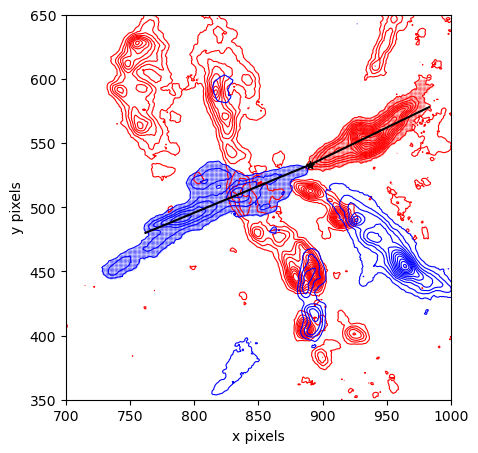

/var/tmp/ballieux/ipykernel_2590352/4171904447.py:17: RuntimeWarning: invalid value encountered in divide
  cos_theta = dot_products / (magnitude_v1 * magnitudes_v2)


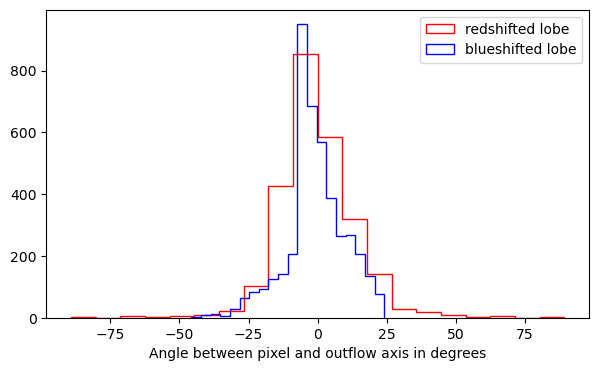

In [75]:
"""  Do A and B completely seperately """

def calculate_angles(v1, v2_x_array, v2_y_array):
    # Vector 1: a 2D vector
    x1, y1 = v1
    
    # Vector 2: arrays of x and y coordinates
    x2_array = np.array(v2_x_array)
    y2_array = np.array(v2_y_array)
    
    # Compute dot products between v1 and each vector in v2
    dot_products = x1 * x2_array + y1 * y2_array
    
    # Magnitudes of vector 1 and each vector in v2
    magnitude_v1 = np.sqrt(x1**2 + y1**2)
    magnitudes_v2 = np.sqrt(x2_array**2 + y2_array**2)
    
    # Compute cosine of angles
    cos_theta = dot_products / (magnitude_v1 * magnitudes_v2)
    
    # To avoid any numerical issues with floating-point precision
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Compute the cross products to determine sign of the angle (+ and - signs are dependent on which vector goes first)
    cross_products =  y1 * x2_array - x1 * y2_array
    # Compute the angles

    angles_radians = np.arccos(cos_theta)
    angles_degrees = np.degrees(angles_radians)

    # Assign negative sign to angles where the cross product is negative
    signed_angles = np.where(cross_products < 0, -angles_radians, angles_radians)
    signed_angles_degrees = np.degrees(signed_angles)
    
    return angles_radians, angles_degrees, signed_angles, signed_angles_degrees

#The vector of the initial guess axis, with protostar as middle point
vector_axis_redA = np.array(point2_redA) - np.array(point1_redA)
vector_axis_blueA = np.array(point2_blueA) - np.array(point1_blueA)

#The red outflow indices where it is not nan, clipped at 3 sigma
outflow_red= np.where(B6_red_clip_unsmoothed.value>0.)
outflow_red_x = outflow_red[1] 
outflow_red_y = outflow_red[0]

#The red outflow indices where it is not nan, clipped at 3 sigma
outflow_blue = np.where(B6_blue_clip_unsmoothed.value>0.)
outflow_blue_x = outflow_blue[1]
outflow_blue_y = outflow_blue[0]

outflow_red_maskA= np.where((outflow_red_x>875)&(outflow_red_x<1000)&(outflow_red_y>525)&(outflow_red_y<600)&(outflow_red_y > 2* outflow_red_x-1380))
outflow_blue_maskA= np.where((outflow_blue_x>700)&(outflow_blue_x<890)&(outflow_blue_y>425)&(outflow_blue_y<550) & (outflow_blue_y>outflow_blue_x-400))

outflow_red_x_maskedA = outflow_red_x[outflow_red_maskA]
outflow_red_y_maskedA = outflow_red_y[outflow_red_maskA]

outflow_blue_x_maskedA = outflow_blue_x[outflow_blue_maskA]
outflow_blue_y_maskedA = outflow_blue_y[outflow_blue_maskA]

#Check the masking
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

#central protostar
plt.scatter(point1_redA[0], point1_redA[1], s=30, color='black', zorder=10, marker='*')

#red
plt.scatter(outflow_red_x_maskedA, outflow_red_y_maskedA, s=1, color='red', alpha=0.1)
plt.plot([point1_redA[0], point2_redA[0]], [point1_redA[1], point2_redA[1]], color='black', zorder=20)
contourlevels_red=np.array([3,8,13,18,23,28,33,38,43,48,53,58,63,68,73,78])*B6_red_rms_unsmoothed
contours_red=ax.contour(B6_red_unsmoothed.value, levels=contourlevels_red, colors='red', linewidths=0.8) #Only place we use unclipped M0 maps


plt.scatter(outflow_blue_x_maskedA, outflow_blue_y_maskedA, s=1, color='blue', alpha=0.1)
plt.plot([point1_blueA[0], point2_blueA[0]], [point1_blueA[1], point2_blueA[1]], color='black', zorder=20)
contourlevels_blue=np.array([3,8,13,18,23,28,33,38,43,48,53,58,63,68,73,78])*B6_blue_rms_unsmoothed
contours_blue=ax.contour(B6_blue_unsmoothed.value, levels=contourlevels_blue, colors='blue', linewidths=0.8) #Only place we use unclipped M0 maps


ax.set_xlim(700,1000)
ax.set_ylim(350,650)

plt.xlabel('x pixels')
plt.ylabel('y pixels')
ax.set_aspect('equal')
plt.savefig(fname=path+'plots/contour+pixels_'+source_name+'.png', dpi=300, bbox_inches='tight')
plt.show()

#For each pixel, determine the vector between that pixel and the protostar
vector_pixel_x_redA = outflow_red_x_maskedA - point1_redA[0]
vector_pixel_y_redA = outflow_red_y_maskedA - point1_redA[1]
vectors_pixel_red = np.array([vector_pixel_x_redA, vector_pixel_y_redA])
angles_radians_redA, angles_degrees_redA, signed_angles_radians_redA, signed_angles_degrees_redA = calculate_angles(vector_axis_redA, vector_pixel_x_redA, vector_pixel_y_redA)
signed_angles_degrees_redA[signed_angles_degrees_redA>90] = 180 - signed_angles_degrees_redA[signed_angles_degrees_redA>90]
signed_angles_degrees_redA[signed_angles_degrees_redA<-90] = -180 - signed_angles_degrees_redA[signed_angles_degrees_redA<-90]

vector_pixel_x_blueA = outflow_blue_x_maskedA - point1_blueA[0]
vector_pixel_y_blueA = outflow_blue_y_maskedA - point1_blueA[1]
vectors_pixel_blueA = np.array([vector_pixel_x_blueA, vector_pixel_y_blueA])
angles_radians_blueA, angles_degrees_blueA, signed_angles_radians_blueA, signed_angles_degrees_blueA = calculate_angles(vector_axis_blueA, vector_pixel_x_blueA, vector_pixel_y_blueA)

signed_angles_degrees_blueA[signed_angles_degrees_blueA>90] = 180 - signed_angles_degrees_blueA[signed_angles_degrees_blueA>90]
signed_angles_degrees_blueA[signed_angles_degrees_blueA<-90] = -180 - signed_angles_degrees_blueA[signed_angles_degrees_blueA<-90]

plt.figure(figsize=(7,4))
plt.hist(signed_angles_degrees_redA, bins=20, histtype='step', color='red', label='redshifted lobe')
plt.hist(signed_angles_degrees_blueA, bins=20, histtype='step', color='blue', label='blueshifted lobe')    
plt.xlabel('Angle between pixel and outflow axis in degrees')

plt.legend()
plt.show()

<>:83: SyntaxWarning: invalid escape sequence '\p'
<>:83: SyntaxWarning: invalid escape sequence '\c'
<>:97: SyntaxWarning: invalid escape sequence '\p'
<>:97: SyntaxWarning: invalid escape sequence '\c'
<>:83: SyntaxWarning: invalid escape sequence '\p'
<>:83: SyntaxWarning: invalid escape sequence '\c'
<>:97: SyntaxWarning: invalid escape sequence '\p'
<>:97: SyntaxWarning: invalid escape sequence '\c'
/var/tmp/ballieux/ipykernel_2590352/2605195850.py:83: SyntaxWarning: invalid escape sequence '\p'
  plt.vlines(mu_redA - 0.5*fwqm_redA, 0, 1.3*a_redA, color='black', linestyle='--', label=f'Angle A= {fwqm_redA:.1f} $\pm$ {e_fwqm_redA:.1f}$^\circ$')
/var/tmp/ballieux/ipykernel_2590352/2605195850.py:83: SyntaxWarning: invalid escape sequence '\c'
  plt.vlines(mu_redA - 0.5*fwqm_redA, 0, 1.3*a_redA, color='black', linestyle='--', label=f'Angle A= {fwqm_redA:.1f} $\pm$ {e_fwqm_redA:.1f}$^\circ$')
/var/tmp/ballieux/ipykernel_2590352/2605195850.py:97: SyntaxWarning: invalid escape sequence '

[  1   0   0   1   4   1   3   3   7  13  22  91 169 575 536 418 299 188
 115  38  17  13   8   6   1   5   3   0   2   1]
[  2   1   8  11   1   6  16  31  46  67  45  65  79  90  99  89 399 669
 490 386 379 290 191 173 184 160 128  99  75  38]
The red outflow angle would then be: 34.9 pm 1.9 degrees
The blue outflow angle would then be: 24.9 pm 2.4 degrees


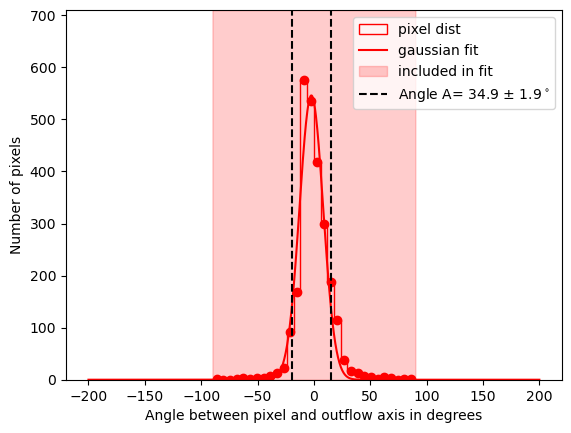

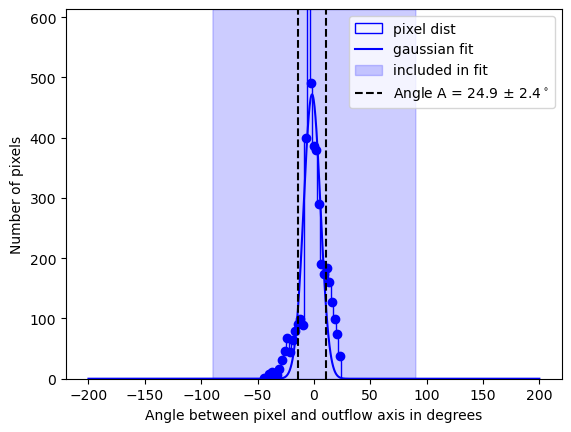

In [135]:
"""
Here, calculate the gaussian distribution of these angles
"""

def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

#fitting parameters
red_minA = -90
red_maxA = 90
bins_redA = 30
p0_redA = [120, 0, 50]

blue_minA = -90
blue_maxA = 90
bins_blueA = 30
p0_blueA = [120, 0, 50]



#Make the histograms
signed_angles_degrees_red_finiteA = signed_angles_degrees_redA[np.isfinite(signed_angles_degrees_redA)] #Deal with any nan angles
hist_redA, binedges_redA= np.histogram(signed_angles_degrees_red_finiteA, bins=bins_redA) #make the histogram so we can fit
bincenters_redA = np.mean(np.vstack([binedges_redA[0:-1],binedges_redA[1:]]), axis=0) #Ensure we have an array of bincenters
print(hist_redA)

signed_angles_degrees_blue_finiteA= signed_angles_degrees_blueA[np.isfinite(signed_angles_degrees_blueA)] #Deal woth any nan angles
hist_blueA, binedges_blueA = np.histogram(signed_angles_degrees_blue_finiteA, bins=bins_blueA) #make the histogram so we can fit
bincenters_blueA = np.mean(np.vstack([binedges_blueA[0:-1],binedges_blueA[1:]]), axis=0) #Ensure we have an array of bincenters
print(hist_blueA)


#Do the masking

mask_redA = (bincenters_redA >= red_minA) & (bincenters_redA <= red_maxA) #here we mask out anything we do not want to include
x_fit_redA = bincenters_redA[mask_redA] #masked bincenters
y_fit_redA = hist_redA[mask_redA] #masked histogram for fitting

# if (source_name == 'Oph_26') or (source_name == 'Oph_27') or (source_name == 'Oph_29') or (source_name == 'Oph_34') or (source_name == 'Oph_39'): #these have a cavity we want to filter out in the red
#     mask_red = ((bincenters_red >= red_min_left) & (bincenters_red <= red_max_left)) \
#           | ((bincenters_red >= red_min_right) & (bincenters_red <= red_max_right))  #here we mask out anything we do not want to include
#     x_fit_red = bincenters_red[mask_red] #masked bincenters
#     y_fit_red = hist_red[mask_red] #masked histogram for fitting

mask_blueA = (bincenters_blueA >= blue_minA) & (bincenters_blueA <= blue_maxA) #here we mask out anything we od not want to include
x_fit_blueA = bincenters_blueA[mask_blueA] #masked bincenters
y_fit_blueA = hist_blueA[mask_blueA] #masked histogram for fitting

# if source_name == 'Oph_34': #Oph_34 has a cavity
#     mask_blue = ((bincenters_blue >= blue_min_left) & (bincenters_blue <= blue_max_left)) \
#           | ((bincenters_blue >= blue_min_right) & (bincenters_blue <= blue_max_right))#here we mask out anything we od not want to include
#     x_fit_blue = bincenters_blue[mask_blue] #masked bincenters
#     y_fit_blue = hist_blue[mask_blue] #masked histogram for fitting


#The fitting for red
popt_redA, pcov_redA = optimize.curve_fit(gaussian, x_fit_redA, y_fit_redA, p0=p0_redA)
a_redA, mu_redA, sigma_redA = popt_redA[0], popt_redA[1], popt_redA[2]
e_sigma_redA= np.sqrt(np.diag(pcov_redA))[2]
fwqm_redA = 2 * np.abs(sigma_redA) * np.sqrt(2 * np.log(4))
e_fwqm_redA = 2 * e_sigma_redA * np.sqrt(2 * np.log(4))

popt_blueA, pcov_blueA = optimize.curve_fit(gaussian, x_fit_blueA, y_fit_blueA, p0=p0_blueA)
a_blueA, mu_blueA, sigma_blueA = popt_blueA[0], popt_blueA[1], popt_blueA[2]
e_sigma_blueA = np.sqrt(np.diag(pcov_blueA))[2]
fwqm_blueA = 2 * np.abs(sigma_blueA) * np.sqrt(2 * np.log(4))
e_fwqm_blueA = 2 * e_sigma_blueA * np.sqrt(2 * np.log(4))

print(f'The red outflow angle would then be: {fwqm_redA:.1f} pm {e_fwqm_redA:.1f} degrees')
if source_name != 'Oph_29' and source_name != 'Oph_31':
    print(f'The blue outflow angle would then be: {fwqm_blueA:.1f} pm {e_fwqm_blueA:.1f} degrees')

#for plotting only
x_plot = np.linspace(-200, 200, 1000)
y_plot_redA = np.linspace(0,a_redA*1.3,1000)
y_plot_blueA = np.linspace(0,a_blueA*1.3,1000)

# Plot the histogram of the data
plt.hist(signed_angles_degrees_redA, bins=bins_redA, color = 'red', histtype = 'step', label='pixel dist')
plt.scatter(bincenters_redA, hist_redA, color = 'red')
plt.plot(x_plot, gaussian(x_plot, popt_redA[0], popt_redA[1], popt_redA[2]), label='gaussian fit', color='red')
plt.fill_betweenx(y_plot_redA, red_minA, red_maxA, color='red', alpha=0.2, label='included in fit')
plt.vlines(mu_redA - 0.5*fwqm_redA, 0, 1.3*a_redA, color='black', linestyle='--', label=f'Angle A= {fwqm_redA:.1f} $\pm$ {e_fwqm_redA:.1f}$^\circ$')
plt.vlines(mu_redA + 0.5*fwqm_redA, 0, 1.3*a_redA, color='black', linestyle='--')
plt.legend()
plt.xlabel('Angle between pixel and outflow axis in degrees')
plt.ylabel('Number of pixels')
plt.ylim(0,a_redA*1.3)
plt.savefig(fname=path+'plots/angledist_red_'+source_name+'.png', dpi=300, bbox_inches='tight')
plt.show()


plt.hist(signed_angles_degrees_blueA, bins=bins_blueA, color = 'blue', histtype = 'step', label='pixel dist')
plt.scatter(bincenters_blueA, hist_blueA, color = 'blue')
plt.plot(x_plot, gaussian(x_plot, popt_blueA[0], popt_blueA[1], popt_blueA[2]), label='gaussian fit', color='blue')
plt.fill_betweenx(y_plot_blueA, blue_minA, blue_maxA, color='blue', alpha=0.2, label='included in fit')
plt.vlines(mu_blueA-0.5*fwqm_blueA, 0, 1.3*a_blueA, color='black', linestyle='--', label=f'Angle A = {fwqm_blueA:.1f} $\pm$ {e_fwqm_blueA:.1f}$^\circ$')
plt.vlines(mu_blueA+0.5*fwqm_blueA, 0, 1.3*a_blueA, color='black', linestyle='--')
plt.legend()
plt.xlabel('Angle between pixel and outflow axis in degrees')
plt.ylabel('Number of pixels')

plt.ylim(0,a_blueA*1.3)
plt.savefig(fname=path+'plots/angledist_blue_'+source_name+'.png', dpi=300, bbox_inches='tight')
plt.show()




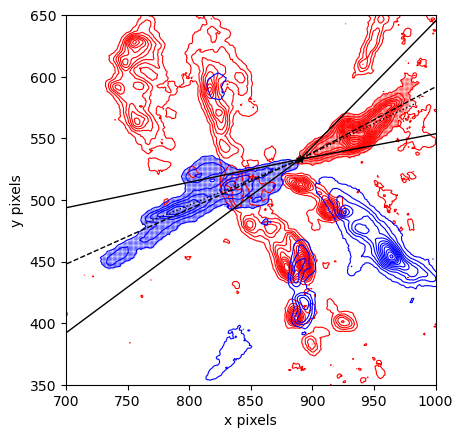

In [125]:
"""    
Same plot, but now with new angles
"""

#Check the masking
fig = plt.figure()
ax = fig.add_subplot(111)

#central protostar
plt.scatter(point1_redA[0], point1_redA[1], s=30, color='black', zorder=10, marker='*')

#red
plt.scatter(outflow_red_x_maskedA, outflow_red_y_maskedA, s=1, color='red', alpha=0.1)
plt.plot([point1_redA[0], point2_redA[0]], [point1_redA[1], point2_redA[1]], color='black', zorder=20, linewidth=1, linestyle=':')
contourlevels_red=np.array([3,8,13,18,23,28,33,38,43,48,53,58,63,68,73,78])*B6_red_rms_unsmoothed
contours_red=ax.contour(B6_red_unsmoothed.value, levels=contourlevels_red, colors='red', linewidths=0.8) #Only place we use unclipped M0 maps

plt.scatter(outflow_blue_x_maskedA, outflow_blue_y_maskedA, s=1, color='blue', alpha=0.1)
plt.plot([point1_blueA[0], point2_blueA[0]], [point1_blueA[1], point2_blueA[1]], color='black', zorder=20, linewidth=1, linestyle=':')
contourlevels_blue=np.array([3,8,13,18,23,28,33,38,43,48,53,58,63,68,73,78])*B6_blue_rms_unsmoothed
contours_blue=ax.contour(B6_blue_unsmoothed.value, levels=contourlevels_blue, colors='blue', linewidths=0.8) #Only place we use unclipped M0 maps

ax.set_xlim(700,1000)
ax.set_ylim(350,650)

plt.xlabel('x pixels')
plt.ylabel('y pixels')
ax.set_aspect('equal')

#Plot the new angles
def rotate_vector(x, y, mu):
    # Calculate the components of the new vector after rotation
    mu = np.radians(mu)
    x_new = x * np.cos(mu) - y * np.sin(mu)
    y_new = x * np.sin(mu) + y * np.cos(mu)
    return np.array([x_new, y_new])

#vector_axis_red is point 2 minus point 1, so assumes point 1 as origin
scaling = 2 #Scaling factor for the new axis, random number, only for plotting
new_axis_redA = rotate_vector(vector_axis_redA[0], vector_axis_redA[1], -mu_redA) * scaling #the new vector from fitted mu. Take negative mu because of conventions
new_axis_blueA = rotate_vector(vector_axis_blueA[0], vector_axis_blueA[1], -mu_blueA) * scaling 

upper_angle_redA = rotate_vector(vector_axis_redA[0], vector_axis_redA[1], -(mu_redA + 0.5*fwqm_redA)) * scaling
lower_angle_redA = rotate_vector(vector_axis_redA[0], vector_axis_redA[1], -(mu_redA - 0.5*fwqm_redA)) * scaling

upper_angle_blueA = rotate_vector(vector_axis_blueA[0], vector_axis_blueA[1], -(mu_blueA + 0.5*fwqm_blueA)) * scaling
lower_angle_blueA = rotate_vector(vector_axis_blueA[0], vector_axis_blueA[1], -(mu_blueA - 0.5*fwqm_blueA)) * scaling

plt.plot([point1_redA[0], point1_redA[0] + new_axis_redA[0]], [point1_redA[1], point1_redA[1] + new_axis_redA[1]], color='black', linestyle='--', linewidth=1)
plt.plot([point1_redA[0], point1_redA[0] + upper_angle_redA[0]], [point1_redA[1], point1_redA[1] + upper_angle_redA[1]], color='black', linestyle='-', linewidth=1)
plt.plot([point1_redA[0], point1_redA[0] + lower_angle_redA[0]], [point1_redA[1], point1_redA[1] + lower_angle_redA[1]], color='black', linestyle='-', linewidth=1)
plt.plot([point1_blueA[0], point1_blueA[0] + new_axis_blueA[0]], [point1_blueA[1], point1_blueA[1] + new_axis_blueA[1]], color='black', linestyle='--', linewidth=1)
plt.plot([point1_blueA[0], point1_blueA[0] + upper_angle_blueA[0]], [point1_blueA[1], point1_blueA[1] + upper_angle_blueA[1]], color='black', linestyle='-', linewidth=1)
plt.plot([point1_blueA[0], point1_blueA[0] + lower_angle_blueA[0]], [point1_blueA[1], point1_blueA[1] + lower_angle_blueA[1]], color='black', linestyle='-', linewidth=1)
plt.savefig(fname=path+'plots/contour+pixels+angles_'+source_name+'_A.png', dpi=300, bbox_inches='tight' )
plt.show()


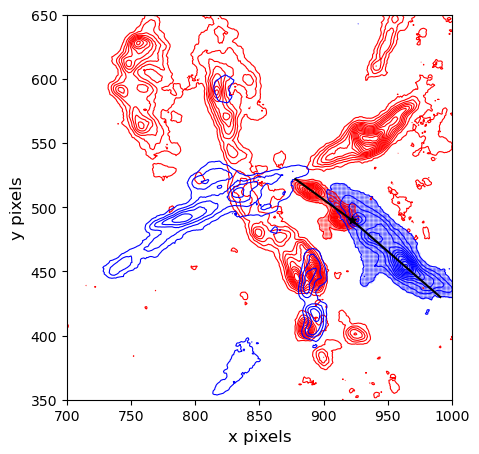

/var/tmp/ballieux/ipykernel_2590352/4171904447.py:17: RuntimeWarning: invalid value encountered in divide
  cos_theta = dot_products / (magnitude_v1 * magnitudes_v2)


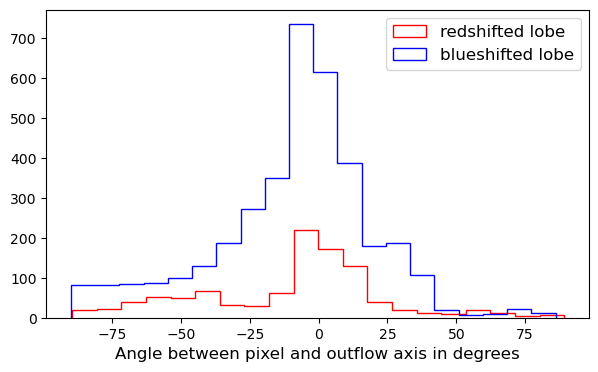

In [144]:
"""  Do B completely seperately """


#The vector of the initial guess axis, with protostar as middle point
vector_axis_redB = np.array(point2_redB) - np.array(point1_redB)
vector_axis_blueB = np.array(point2_blueB) - np.array(point1_blueB)

#The red outflow indices where it is not nan, clipped at 3 sigma
outflow_red= np.where(B6_red_clip_unsmoothed.value>0.)
outflow_red_x = outflow_red[1] 
outflow_red_y = outflow_red[0]

#The red outflow indices where it is not nan, clipped at 3 sigma
outflow_blue = np.where(B6_blue_clip_unsmoothed.value>0.)
outflow_blue_x = outflow_blue[1]
outflow_blue_y = outflow_blue[0]

outflow_red_maskB= np.where((outflow_red_x>875)&(outflow_red_x<930)&(outflow_red_y>470)&(outflow_red_y<525)&(outflow_red_y > -1* outflow_red_x+1375))
outflow_blue_maskB= np.where((outflow_blue_x>900)&(outflow_blue_x<1000)&(outflow_blue_y>425)&(outflow_blue_y<550))# & (outflow_blue_y>outflow_blue_x-400))

outflow_red_x_maskedB = outflow_red_x[outflow_red_maskB]
outflow_red_y_maskedB = outflow_red_y[outflow_red_maskB]

outflow_blue_x_maskedB = outflow_blue_x[outflow_blue_maskB]
outflow_blue_y_maskedB = outflow_blue_y[outflow_blue_maskB]

#Check the masking
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

#central protostar
plt.scatter(point1_redB[0], point1_redB[1], s=30, color='black', zorder=10, marker='*')

# red
plt.scatter(outflow_red_x_maskedB, outflow_red_y_maskedB, s=1, color='red', alpha=0.1)
plt.plot([point1_redB[0], point2_redB[0]], [point1_redB[1], point2_redB[1]], color='black', zorder=20)
contourlevels_red=np.array([3,8,13,18,23,28,33,38,43,48,53,58,63,68,73,78])*B6_red_rms_unsmoothed
contours_red=ax.contour(B6_red_unsmoothed.value, levels=contourlevels_red, colors='red', linewidths=0.8) #Only place we use unclipped M0 maps


plt.scatter(outflow_blue_x_maskedB, outflow_blue_y_maskedB, s=1, color='blue', alpha=0.1)
plt.plot([point1_blueB[0], point2_blueB[0]], [point1_blueB[1], point2_blueB[1]], color='black', zorder=20)
contourlevels_blue=np.array([3,8,13,18,23,28,33,38,43,48,53,58,63,68,73,78])*B6_blue_rms_unsmoothed
contours_blue=ax.contour(B6_blue_unsmoothed.value, levels=contourlevels_blue, colors='blue', linewidths=0.8) #Only place we use unclipped M0 maps


ax.set_xlim(700,1000)
ax.set_ylim(350,650)

plt.xlabel('x pixels')
plt.ylabel('y pixels')
ax.set_aspect('equal')
plt.savefig(fname=path+'plots/contour+pixels_'+source_name+'.png', dpi=500, bbox_inches='tight')
plt.show()

#For each pixel, determine the vector between that pixel and the protostar
vector_pixel_x_redB = outflow_red_x_maskedB - point1_redB[0]
vector_pixel_y_redB = outflow_red_y_maskedB - point1_redB[1]
vectors_pixel_red = np.array([vector_pixel_x_redB, vector_pixel_y_redB])
angles_radians_redB, angles_degrees_redB, signed_angles_radians_redB, signed_angles_degrees_redB = calculate_angles(vector_axis_redB, vector_pixel_x_redB, vector_pixel_y_redB)
signed_angles_degrees_redB[signed_angles_degrees_redB>90] = 180 - signed_angles_degrees_redB[signed_angles_degrees_redB>90]
signed_angles_degrees_redB[signed_angles_degrees_redB<-90] = -180 - signed_angles_degrees_redB[signed_angles_degrees_redB<-90]

vector_pixel_x_blueB = outflow_blue_x_maskedB - point1_blueB[0]
vector_pixel_y_blueB = outflow_blue_y_maskedB - point1_blueB[1]
vectors_pixel_blueB = np.array([vector_pixel_x_blueB, vector_pixel_y_blueB])
angles_radians_blueB, angles_degrees_blueB, signed_angles_radians_blueB, signed_angles_degrees_blueB = calculate_angles(vector_axis_blueB, vector_pixel_x_blueB, vector_pixel_y_blueB)

signed_angles_degrees_blueB[signed_angles_degrees_blueB>90] = 180 - signed_angles_degrees_blueB[signed_angles_degrees_blueB>90]
signed_angles_degrees_blueB[signed_angles_degrees_blueB<-90] = -180 - signed_angles_degrees_blueB[signed_angles_degrees_blueB<-90]

plt.figure(figsize=(7,4))
plt.hist(signed_angles_degrees_redB, bins=20, histtype='step', color='red', label='redshifted lobe')
plt.hist(signed_angles_degrees_blueB, bins=20, histtype='step', color='blue', label='blueshifted lobe')    
plt.xlabel('Angle between pixel and outflow axis in degrees')

plt.legend()
plt.show()

<>:83: SyntaxWarning: invalid escape sequence '\p'
<>:83: SyntaxWarning: invalid escape sequence '\c'
<>:97: SyntaxWarning: invalid escape sequence '\p'
<>:97: SyntaxWarning: invalid escape sequence '\c'
<>:83: SyntaxWarning: invalid escape sequence '\p'
<>:83: SyntaxWarning: invalid escape sequence '\c'
<>:97: SyntaxWarning: invalid escape sequence '\p'
<>:97: SyntaxWarning: invalid escape sequence '\c'
/var/tmp/ballieux/ipykernel_2590352/3276154029.py:83: SyntaxWarning: invalid escape sequence '\p'
  plt.vlines(mu_redB - 0.5*fwqm_redB, 0, 1.3*a_redB, color='black', linestyle='--', label=f'angle={fwqm_redB:.1f} $\pm$ {e_fwqm_redB:.1f}$^\circ$')
/var/tmp/ballieux/ipykernel_2590352/3276154029.py:83: SyntaxWarning: invalid escape sequence '\c'
  plt.vlines(mu_redB - 0.5*fwqm_redB, 0, 1.3*a_redB, color='black', linestyle='--', label=f'angle={fwqm_redB:.1f} $\pm$ {e_fwqm_redB:.1f}$^\circ$')
/var/tmp/ballieux/ipykernel_2590352/3276154029.py:97: SyntaxWarning: invalid escape sequence '\p'
  

[ 20  21  39  51  50  68  33  30  63 220 171 130  40  19  13   9  20  13
   4   8]
[ 80  77  80  82  98 109 154 230 281 549 680 504 259 167 173  66  18   8
   9  23  10]
The red outflow angle would then be: 38.8 pm 3.7 degrees
The blue outflow angle would then be: 57.4 pm 4.4 degrees


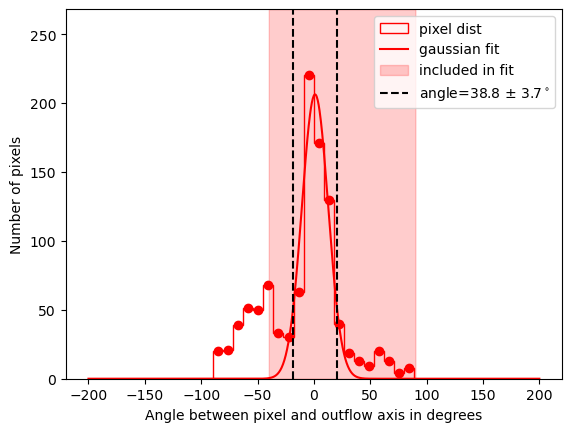

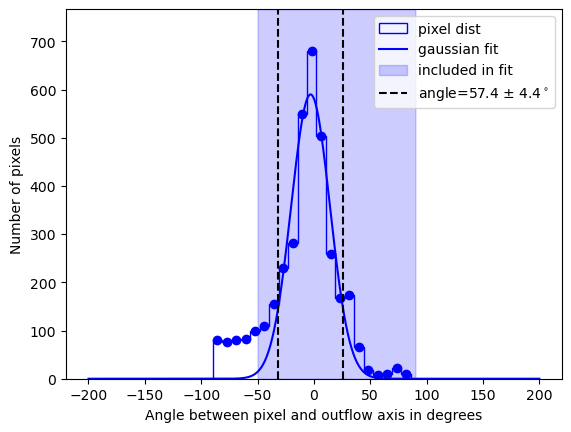

In [127]:
"""
Here, calculate the gaussian distribution of these angles
"""

def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

#fitting parameters
red_minB = -40
red_maxB = 90
bins_redB = 20
p0_redB = [120, 0, 50]

blue_minB = -50
blue_maxB = 90
bins_blueB = 21
p0_blueB = [120, 0, 50]



#Make the histograms
signed_angles_degrees_red_finiteB = signed_angles_degrees_redB[np.isfinite(signed_angles_degrees_redB)] #Deal with any nan angles
hist_redB, binedges_redB= np.histogram(signed_angles_degrees_red_finiteB, bins=bins_redB) #make the histogram so we can fit
bincenters_redB = np.mean(np.vstack([binedges_redB[0:-1],binedges_redB[1:]]), axis=0) #Ensure we have an array of bincenters
print(hist_redB)

signed_angles_degrees_blue_finiteB= signed_angles_degrees_blueB[np.isfinite(signed_angles_degrees_blueB)] #Deal woth any nan angles
hist_blueB, binedges_blueB = np.histogram(signed_angles_degrees_blue_finiteB, bins=bins_blueB) #make the histogram so we can fit
bincenters_blueB = np.mean(np.vstack([binedges_blueB[0:-1],binedges_blueB[1:]]), axis=0) #Ensure we have an array of bincenters
print(hist_blueB)


#Do the masking

mask_redB = (bincenters_redB >= red_minB) & (bincenters_redB <= red_maxB) #here we mask out anything we do not want to include
x_fit_redB = bincenters_redB[mask_redB] #masked bincenters
y_fit_redB = hist_redB[mask_redB] #masked histogram for fitting

# if (source_name == 'Oph_26') or (source_name == 'Oph_27') or (source_name == 'Oph_29') or (source_name == 'Oph_34') or (source_name == 'Oph_39'): #these have a cavity we want to filter out in the red
#     mask_red = ((bincenters_red >= red_min_left) & (bincenters_red <= red_max_left)) \
#           | ((bincenters_red >= red_min_right) & (bincenters_red <= red_max_right))  #here we mask out anything we do not want to include
#     x_fit_red = bincenters_red[mask_red] #masked bincenters
#     y_fit_red = hist_red[mask_red] #masked histogram for fitting

mask_blueB = (bincenters_blueB >= blue_minB) & (bincenters_blueB <= blue_maxB) #here we mask out anything we od not want to include
x_fit_blueB = bincenters_blueB[mask_blueB] #masked bincenters
y_fit_blueB = hist_blueB[mask_blueB] #masked histogram for fitting

# if source_name == 'Oph_34': #Oph_34 has a cavity
#     mask_blue = ((bincenters_blue >= blue_min_left) & (bincenters_blue <= blue_max_left)) \
#           | ((bincenters_blue >= blue_min_right) & (bincenters_blue <= blue_max_right))#here we mask out anything we od not want to include
#     x_fit_blue = bincenters_blue[mask_blue] #masked bincenters
#     y_fit_blue = hist_blue[mask_blue] #masked histogram for fitting


#The fitting for red
popt_redB, pcov_redB = optimize.curve_fit(gaussian, x_fit_redB, y_fit_redB, p0=p0_redB)
a_redB, mu_redB, sigma_redB = popt_redB[0], popt_redB[1], popt_redB[2]
e_sigma_redB= np.sqrt(np.diag(pcov_redB))[2]
fwqm_redB = 2 * sigma_redB * np.sqrt(2 * np.log(4))
e_fwqm_redB = 2 * e_sigma_redB * np.sqrt(2 * np.log(4))

popt_blueB, pcov_blueB = optimize.curve_fit(gaussian, x_fit_blueB, y_fit_blueB, p0=p0_blueB)
a_blueB, mu_blueB, sigma_blueB = popt_blueB[0], popt_blueB[1], popt_blueB[2]
e_sigma_blueB = np.sqrt(np.diag(pcov_blueB))[2]
fwqm_blueB = 2 * sigma_blueB * np.sqrt(2 * np.log(4))
e_fwqm_blueB = 2 * e_sigma_blueB * np.sqrt(2 * np.log(4))

print(f'The red outflow angle would then be: {fwqm_redB:.1f} pm {e_fwqm_redB:.1f} degrees')
if source_name != 'Oph_29' and source_name != 'Oph_31':
    print(f'The blue outflow angle would then be: {fwqm_blueB:.1f} pm {e_fwqm_blueB:.1f} degrees')

#for plotting only
x_plot = np.linspace(-200, 200, 1000)
y_plot_redB = np.linspace(0,a_redB*1.3,1000)
y_plot_blueB = np.linspace(0,a_blueB*1.3,1000)

# Plot the histogram of the data
plt.hist(signed_angles_degrees_redB, bins=bins_redB, color = 'red', histtype = 'step', label='pixel dist')
plt.scatter(bincenters_redB, hist_redB, color = 'red')
plt.plot(x_plot, gaussian(x_plot, popt_redB[0], popt_redB[1], popt_redB[2]), label='gaussian fit', color='red')
plt.fill_betweenx(y_plot_redB, red_minB, red_maxB, color='red', alpha=0.2, label='included in fit')
plt.vlines(mu_redB - 0.5*fwqm_redB, 0, 1.3*a_redB, color='black', linestyle='--', label=f'angle={fwqm_redB:.1f} $\pm$ {e_fwqm_redB:.1f}$^\circ$')
plt.vlines(mu_redB + 0.5*fwqm_redB, 0, 1.3*a_redB, color='black', linestyle='--')
plt.legend()
plt.xlabel('Angle between pixel and outflow axis in degrees')
plt.ylabel('Number of pixels')
plt.ylim(0,a_redB*1.3)
plt.savefig(fname=path+'plots/angledist_red_'+source_name+'.png', dpi=300, bbox_inches='tight')
plt.show()


plt.hist(signed_angles_degrees_blueB, bins=bins_blueB, color = 'blue', histtype = 'step', label='pixel dist')
plt.scatter(bincenters_blueB, hist_blueB, color = 'blue')
plt.plot(x_plot, gaussian(x_plot, popt_blueB[0], popt_blueB[1], popt_blueB[2]), label='gaussian fit', color='blue')
plt.fill_betweenx(y_plot_blueB, blue_minB, blue_maxB, color='blue', alpha=0.2, label='included in fit')
plt.vlines(mu_blueB-0.5*fwqm_blueB, 0, 1.3*a_blueB, color='black', linestyle='--', label=f'angle={fwqm_blueB:.1f} $\pm$ {e_fwqm_blueB:.1f}$^\circ$')
plt.vlines(mu_blueB+0.5*fwqm_blueB, 0, 1.3*a_blueB, color='black', linestyle='--')
plt.legend()
plt.xlabel('Angle between pixel and outflow axis in degrees')
plt.ylabel('Number of pixels')

plt.ylim(0,a_blueB*1.3)
plt.savefig(fname=path+'plots/angledist_blue_'+source_name+'.png', dpi=300, bbox_inches='tight')
plt.show()




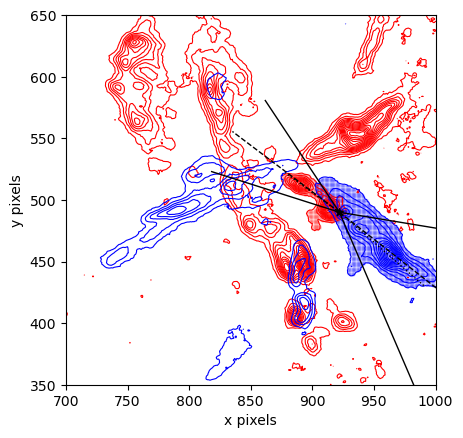

In [128]:
"""    
Same plot, but now with new angles
"""

#Check the masking
fig = plt.figure()
ax = fig.add_subplot(111)

#central protostar
plt.scatter(point1_redB[0], point1_redB[1], s=30, color='black', zorder=10, marker='*')

#red
plt.scatter(outflow_red_x_maskedB, outflow_red_y_maskedB, s=1, color='red', alpha=0.1)
plt.plot([point1_redB[0], point2_redB[0]], [point1_redB[1], point2_redB[1]], color='black', zorder=20, linewidth=1, linestyle=':')
contourlevels_red=np.array([3,8,13,18,23,28,33,38,43,48,53,58,63,68,73,78])*B6_red_rms_unsmoothed
contours_red=ax.contour(B6_red_unsmoothed.value, levels=contourlevels_red, colors='red', linewidths=0.8) #Only place we use unclipped M0 maps

plt.scatter(outflow_blue_x_maskedB, outflow_blue_y_maskedB, s=1, color='blue', alpha=0.1)
plt.plot([point1_blueB[0], point2_blueB[0]], [point1_blueB[1], point2_blueB[1]], color='black', zorder=20, linewidth=1, linestyle=':')
contourlevels_blue=np.array([3,8,13,18,23,28,33,38,43,48,53,58,63,68,73,78])*B6_blue_rms_unsmoothed
contours_blue=ax.contour(B6_blue_unsmoothed.value, levels=contourlevels_blue, colors='blue', linewidths=0.8) #Only place we use unclipped M0 maps

ax.set_xlim(700,1000)
ax.set_ylim(350,650)

plt.xlabel('x pixels')
plt.ylabel('y pixels')
ax.set_aspect('equal')

#Plot the new angles
def rotate_vector(x, y, mu):
    # Calculate the components of the new vector after rotation
    mu = np.radians(mu)
    x_new = x * np.cos(mu) - y * np.sin(mu)
    y_new = x * np.sin(mu) + y * np.cos(mu)
    return np.array([x_new, y_new])

#vector_axis_red is point 2 minus point 1, so assumes point 1 as origin
scaling = 2 #Scaling factor for the new axis, random number, only for plotting
new_axis_redB = rotate_vector(vector_axis_redB[0], vector_axis_redB[1], -mu_redB) * scaling #the new vector from fitted mu. Take negative mu because of conventions
new_axis_blueB = rotate_vector(vector_axis_blueB[0], vector_axis_blueB[1], -mu_blueB) * scaling 

upper_angle_redB = rotate_vector(vector_axis_redB[0], vector_axis_redB[1], -(mu_redB + 0.5*fwqm_redB)) * scaling
lower_angle_redB = rotate_vector(vector_axis_redB[0], vector_axis_redB[1], -(mu_redB - 0.5*fwqm_redB)) * scaling

upper_angle_blueB = rotate_vector(vector_axis_blueB[0], vector_axis_blueB[1], -(mu_blueB + 0.5*fwqm_blueB)) * scaling
lower_angle_blueB = rotate_vector(vector_axis_blueB[0], vector_axis_blueB[1], -(mu_blueB - 0.5*fwqm_blueB)) * scaling

plt.plot([point1_redB[0], point1_redB[0] + new_axis_redB[0]], [point1_redB[1], point1_redB[1] + new_axis_redB[1]], color='black', linestyle='--', linewidth=1)
plt.plot([point1_redB[0], point1_redB[0] + upper_angle_redB[0]], [point1_redB[1], point1_redB[1] + upper_angle_redB[1]], color='black', linestyle='-', linewidth=1)
plt.plot([point1_redB[0], point1_redB[0] + lower_angle_redB[0]], [point1_redB[1], point1_redB[1] + lower_angle_redB[1]], color='black', linestyle='-', linewidth=1)
plt.plot([point1_blueB[0], point1_blueB[0] + new_axis_blueB[0]], [point1_blueB[1], point1_blueB[1] + new_axis_blueB[1]], color='black', linestyle='--', linewidth=1)
plt.plot([point1_blueB[0], point1_blueB[0] + upper_angle_blueB[0]], [point1_blueB[1], point1_blueB[1] + upper_angle_blueB[1]], color='black', linestyle='-', linewidth=1)
plt.plot([point1_blueB[0], point1_blueB[0] + lower_angle_blueB[0]], [point1_blueB[1], point1_blueB[1] + lower_angle_blueB[1]], color='black', linestyle='-', linewidth=1)
plt.savefig(fname=path+'plots/contour+pixels+angles_'+source_name+'_B.png', dpi=300, bbox_inches='tight' )
plt.show()
